# Aprendizaje Automático - Práctica 2 - Complejidad de H y Modelos Lineales

#### Valoración máxima: 12 puntos (+1.5 puntos de Bonus)

#### Fecha límite de entrega: 7 de Mayo de 2023 a las 23:59

#### Entrega a través de https://pradogrado2223.ugr.es/

### Nombre completo: <mark>Alejandro Nieto Alarcón</mark>



---

Este trabajo, cuya puntuación máxima será de 12 puntos (+1.5 puntos de bonus), pretende servir como práctica y refuerzo de los conocimientos adquiridos en teoría, relativos a modelos lineales de clasificación.

Límite de entrega: **7 de Mayo de 2023 a las 23:59 (PRADO)**


**Normas de desarrollo y entrega de trabajos**

- Única y exclusivamente se debe entregar este Notebook de Colab (fichero .ipynb). No es necesario entregar ninguna memoria externa, pero el código debe estar bien comentado, y todas las decisiones tomadas y el trabajo desarrollado deben documentarse suficientemente en celdas de texto. 

- La entrega en PRADO está configurada para permitir sucesivas entregas de la práctica. Desde este punto de vista, se recomienda subir versiones de la práctica a medida que se van realizando los distintos ejercicios propuestos, y no dejarlo todo para el final, dado que es altamente improbable que se extienda la fecha de entrega.  

- Reiterar que es obligatorio documentar las valoraciones y decisiones adoptadas en el desarrollo de cada uno de los apartados. Debe incluirse también una valoración razonada sobre la calidad de los
resultados obtenidos. Sin esta documentación, se considera que el trabajo NO ha sido presentado. 

- Se debe respetar la estructura y secciones del Notebook. Esto servirá para agilizar las correcciones, así como para identificar con facilidad qué ejercicio/apartado se está respondiendo. 

- El codigo NO puede escribir nada a disco.

- El path de lectura desde Google Drive debe ser siempre el mismo, que es el que se indica en este Notebook. 

- Una entrega es apta para ser corregida si se puede ejecutar de principio a fin sin errores.

- No es válido usar opciones en las entradas (es decir, utilizar el comando `input`, por ejemplo, para que el usuario escoja el valor de las variables para ejecutar el programa). Para ello, se deben fijar al comienzo los valores
por defecto que se consideren óptimos o que se soliciten en el enunciado.

- El código debe estar obligatoriamente comentado explicando lo que realizan los distintos apartados y/o bloques.

- Se entrega solamente este Notebook, y no los datos empleados.


---

## <font color='blue'>Ejercicio 1: COMPLEJIDAD DE H Y EL RUIDO (4 puntos)</font>

<font color='blue'>En este ejercicio intentaremos profundizar un poco en la dificultad que introduce el ruido de las etiquetas en la elección de la clase de funciones más adecuada para resolver un determinado problema. 



In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tabulate import tabulate
import random


# Fijamos la semilla aleatoria
np.random.seed(1)

<font color='blue'>Haremos uso de tres funciones, que se incluyen a continuación: 

<font color='blue'>$simula\_unif(N, dim, rango)$, que calcula una lista de $N$ vectores de dimensión $dim$. Cada vector contiene $dim$ números aleatorios uniformes en el intervalo $rango$.

In [2]:
def simula_unif(N, dim, rango):
	return np.random.uniform(rango[0],rango[1],(N,dim))

<font color='blue'>$simula\_gauss(N, dim, sigma)$, que calcula una lista de longitud $N$ de vectores de dimensión $dim$, donde cada posición del vector contiene un número aleatorio extraído de una distribucción Gaussiana de media 0 y varianza dada (para cada dimension, por la posición del vector $sigma$).

In [3]:
def simula_gauss(N, dim, sigma):
    media = 0    
    out = np.zeros((N,dim),np.float64)        
    for i in range(N):
        # Para cada columna dim se emplea un sigma determinado. Es decir, para 
        # la primera columna (eje X) se usará una N(0,sqrt(sigma[0])) 
        # y para la segunda (eje Y) N(0,sqrt(sigma[1]))
        out[i,:] = np.random.normal(loc=media, scale=np.sqrt(sigma), size=dim)
    
    return out

<font color='blue'>$simula\_recta(intervalo)$, que simula de forma aleatoria los parámetros $v = (a, b)$ de una
recta, $y = ax + b$, dado un determinado intervalo (dentro del cual se generan dos puntos aleatorios, que se emplearán para calcular la pendiente y el término independiente de la recta).

In [4]:
def simula_recta(intervalo):
    points = np.random.uniform(intervalo[0], intervalo[1], size=(2, 2))
    x1 = points[0,0]
    x2 = points[1,0]
    y1 = points[0,1]
    y2 = points[1,1]
    # y = a*x + b
    a = (y2-y1)/(x2-x1) # Cálculo de la pendiente.
    b = y1 - a*x1       # Cálculo del termino independiente.
    
    return a, b

#### <font color='blue'>a)  (1 punto) Visualización de puntos iniciales.

<font color='blue'>Vamos a valorar la influencia del ruido en la selección de la clase de funciones y su complejidad. Con ayuda de la función $simula\_unif()$ generamos una
muestra de 100 puntos 2D, en el intervalo $[-50, 50]$,  a los que vamos añadir una etiqueta usando el signo de la función $f(x, y) = y - ax - b$, es decir el signo de la distancia de cada punto a la recta simulada con
$simula\_recta()$.

Dibujar un gráfico 2D con los puntos etiquetados. Dibuje también la recta usada para etiquetar. Observe y verifique (por medio del error de clasificación) que todos los puntos están bien clasificados respecto de la recta.
</font>


In [5]:
"""
np.sign(0) da 0 (véase https://numpy.org/doc/stable/reference/generated/numpy.sign.html), lo que, en ciertas ocasiones, puede ser problemático
Por ese motivo, proporcionamos esta sencilla función que devuelve el signo del valor que se le proporciona como entrada
Si esta función se emplea con un array, se obtendrá el error "ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()"
Si quiere poder emplearse con arrays, bastaría vectorizarla:
		numeros = np.random.randint(-10,10,10)
		sgn = np.vectorize(signo)
		print(numeros)
		print(sgn(numeros))
"""
def signo(x):
	if x >= 0:
		return 1
	return -1

def f(x, y, a, b):
	return signo(y - a*x - b)
 
#Funcion para introducir ruido un determinado porcentaje de ruido en las etiquetas
def introducir_ruido(y,porcent_ruido):
	a = np.where(y == 1)[0]
	b = np.where(y == -1)[0]

	min_changes = round(len(a) * porcent_ruido)
	np.random.shuffle(a)
	indexes = a[0:min_changes]
	y[indexes] = -1

	other_changes = round(len(b) * porcent_ruido)
	np.random.shuffle(b)
	indexes = b[0:other_changes]
	y[indexes] = 1
 
	return y
 
def get_data_set(intervalo, noise):
  x = simula_unif(100, 2, intervalo)
  lin_values = simula_recta(intervalo)
  y = []
  for i in range(x.shape[0]):
    y.append(f(x[i,0], x[i,1], lin_values[0], lin_values[1]))
    
  y = np.array(y)
  y_noise = introducir_ruido(y.copy(), 0.1)
  x = np.c_[np.ones(len(x)), x]

  x_test = simula_unif(999, 2, intervalo)
  y_test = []
  for i in range(x_test.shape[0]):
    y_test.append(f(x_test[i,0], x_test[i,1], lin_values[0], lin_values[1]))
    
  y_test = np.array(y_test)
  y_test_noise = introducir_ruido(y_test.copy(), 0.1)
  x_test = np.c_[np.ones(len(x_test)), x_test]
  
  if noise == 1:
    return x, y_noise, x_test, y_test_noise, lin_values

  return x, y, x_test, y_test, lin_values


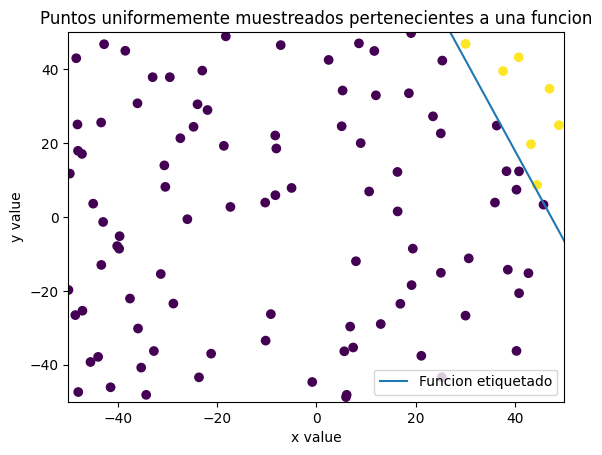

In [6]:
intervalo = [-50,50]

#Obtenemos el conjunto de datos
x = simula_unif(100, 2, intervalo)
#Obtenemos la recta de etiquetado
lin_values = simula_recta(intervalo)

#Generamos la etiqueta que le pertenece a cada dato
y = []
for i in range(x.shape[0]):
  y.append(f(x[i,0], x[i,1], lin_values[0], lin_values[1]))
y = np.array(y)


xx = np.linspace(intervalo[0], intervalo[1], num=100)
yy = lin_values[0] * xx + lin_values[1]
plt.figure()
plt.xlim(intervalo)
plt.ylim(intervalo)
plt.title("Puntos uniformemente muestreados pertenecientes a una funcion")
plt.scatter(x[:,0],x[:,1], c=y)
plt.plot(xx, yy, label = "Funcion etiquetado")
plt.xlabel("x value")
plt.ylabel("y value")
plt.legend()
plt.show()

#### <font color='blue'>b) (0.5 puntos)  Introducción de ruido. 
Modifique de forma aleatoria un 10\% de las etiquetas positivas y otro
10\% de las negativas y guarde los puntos con sus nuevas etiquetas. Dibuje de nuevo
la gráfica anterior. Ahora habrá puntos mal clasificados respecto de la recta.</font>


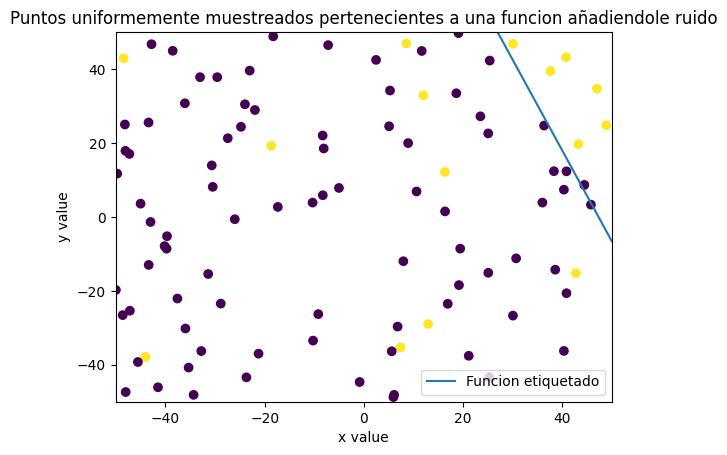

In [7]:
#Obtenemos el etiquetado con ruido
y_noise = introducir_ruido(y.copy(), 0.1)

xx = np.linspace(intervalo[0], intervalo[1], num=100)
yy = lin_values[0] * xx + lin_values[1]
plt.figure()
plt.xlim(intervalo)
plt.ylim(intervalo)
plt.title("Puntos uniformemente muestreados pertenecientes a una funcion añadiendole ruido")
plt.scatter(x[:,0],x[:,1], c=y_noise)
plt.plot(xx, yy, label = "Funcion etiquetado")
plt.xlabel("x value")
plt.ylabel("y value")
plt.legend()
plt.show()

#### <font color='blue'>c) (2.5 puntos)  Análisis y comparación de distintas fronteras de decisión. 
Supongamos ahora que las siguientes funciones definen la frontera de
clasificación de los puntos de la muestra en lugar de una recta.</font>

<font color='blue'>$f_1(x, y) = (x - 10)^2 + (y - 20)^2 - 400$</font>

<font color='blue'>$f_2(x, y) = 0.5(x + 10)^2 + (y - 20)^2 - 400$</font>

<font color='blue'>$f_3(x, y) = 0.5(x - 10)^2 - (y + 20)^2 - 400$</font>

<font color='blue'>$f_4(x, y) = y - 20x^2 - 5x + 3$</font>


<font color='blue'>

Visualizar el etiquetado generado en el Apartado (b) junto con la gráfica de cada
una de las funciones. Muéstrense los porcentajes de acierto en clasificación para las funciones (es decir, fronteras de decisión) evaluadas. Argumente si estas funciones más
complejas son mejores clasificadores que la función lineal. Observe las gráficas y diga
qué consecuencias extrae sobre la influencia de la modificación de etiquetas
en el proceso de aprendizaje. En concreto, razone sobre cuestiones como las siguientes: ¿Necesariamente funciones más complejas son mejores clasificadores (es decir, representan “mejores” bordes de decisión)? ¿Es posible superar/mejorar ese 10% de error de clasificación? ¿Qué pasa si repetimos el proceso con estas funciones más complejas (las empleamos para etiquetar los datos y luego metemos un 10% de ruido)? ¿Qué error de clasificación tenemos? ¿Es menor que ese 10%?
</font>



In [8]:
def f1(x):
  x1 = x[:, 0]
  y = x[:, 1]
  return (x1-10)**2 + (y-20)**2 - 400

def f2(x):
  x1 = x[:, 0]
  y = x[:, 1]
  return 0.5*(x1+10)**2 + (y-20)**2 - 400

def f3(x):
  x1 = x[:, 0]
  y = x[:, 1]
  return 0.5*(x1-10)**2 - (y+20)**2 - 400

def f4(x):
  x1 = x[:, 0]
  y = x[:, 1]
  return y - 20*(x1**2) - 5*x1 + 3

def MC_rate(x, y, f):
  y_pred = f(x)
  y_pred[y_pred >= 0] = 1
  y_pred[y_pred < 0] = -1
  arr_p = np.where((y-y_pred) == 0)
  errores = len(y) - len(arr_p[0])
  return errores/len(y) * 100

In [9]:
"""
Esta función permite visualizar las fronteras de decisión.

Entradas: 
- X: datos de entrada con tantas filas como ejemplos, y tantas columnas como dimensiones/features
- y: etiquetas
- fz: función que define la frontera de decisión
- title: título que se le quiere poner a la figura
- xaxis: nombre que se le quiere poner al eje X
- yaxis: nombre que se le quiere poner al eje Y

Salida: visualización de los datos junto con la frontera de decisión proporcionada

Ejemplo de uso: 
def f_prueba(X):
	return X[:,0]**2 + X[:,1]**2 - 200
plot_datos_cuad(X, y, f_prueba, title=r'$f_{prueba}(x, y) = x^2 + y^2 - 200$')
"""
def plot_datos_cuad(X, y, fz, title='Point cloud plot', xaxis='x axis', yaxis='y axis'):
    #Preparar datos
    min_xy = X.min(axis=0)
    max_xy = X.max(axis=0)
    border_xy = (max_xy-min_xy)*0.01
    
    #Generar grid de predicciones
    # np.mgrid es una versión multidimensional de meshgrid (https://numpy.org/doc/stable/reference/generated/numpy.mgrid.html)
    xx, yy = np.mgrid[min_xy[0]-border_xy[0]:max_xy[0]+border_xy[0]+0.001:border_xy[0], 
                      min_xy[1]-border_xy[1]:max_xy[1]+border_xy[1]+0.001:border_xy[1]]
    # np.ravel "aplana" un array (https://numpy.org/doc/stable/reference/generated/numpy.ravel.html)
    # Diferencias entre ravel y flatten: https://stackoverflow.com/questions/28930465/what-is-the-difference-between-flatten-and-ravel-functions-in-numpy
    # np.c_ permite concatenar arrays a lo largo del segundo eje (https://numpy.org/doc/stable/reference/generated/numpy.c_.html)
    grid = np.c_[xx.ravel(), yy.ravel(), np.ones_like(xx).ravel()]
    pred_y = np.sign(fz(grid)).reshape(xx.shape)

    #Plot
    f, ax = plt.subplots(figsize=(8, 6))
    contour = ax.contourf(xx, yy, pred_y, 50, cmap='RdBu',vmin=-1, vmax=1)
    ax_c = f.colorbar(contour)
    ax_c.set_label('$f(x, y)$')
    ax_c.set_ticks([-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, linewidth=1, 
                cmap="RdYlBu", edgecolor='white')
    
    XX, YY = np.meshgrid(np.linspace(round(min(min_xy)), round(max(max_xy)),X.shape[0]),np.linspace(round(min(min_xy)), round(max(max_xy)),X.shape[0]))
    positions = np.vstack([XX.ravel(), YY.ravel()])
    # ax.contour(XX,YY,fz(positions.T).reshape(X.shape[0],X.shape[0]),[0], colors='white')
    
    ax.set(
       xlim=(min_xy[0]-border_xy[0], max_xy[0]+border_xy[0]), 
       ylim=(min_xy[1]-border_xy[1], max_xy[1]+border_xy[1]),
       xlabel=xaxis, ylabel=yaxis)
    plt.title(title)
    plt.show()

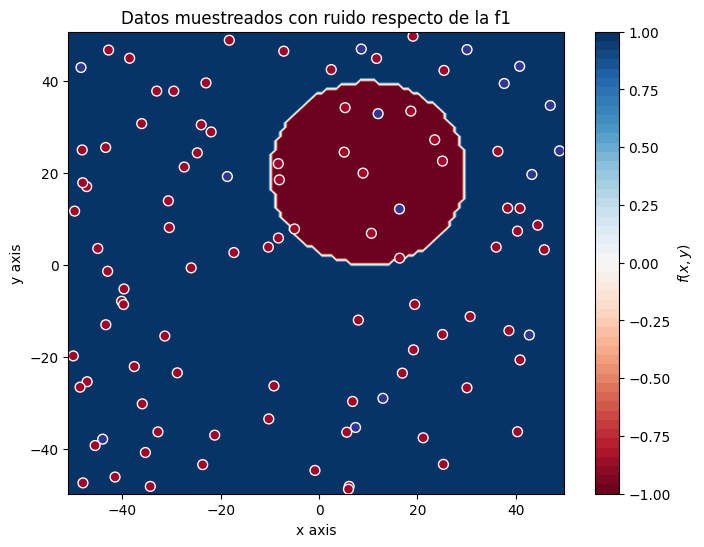

Misclassification rate: 76.0%


In [10]:
plot_datos_cuad(x, y_noise, f1, title="Datos muestreados con ruido respecto de la f1")
print('Misclassification rate: {}%'.format(MC_rate(x, y_noise, f1)))

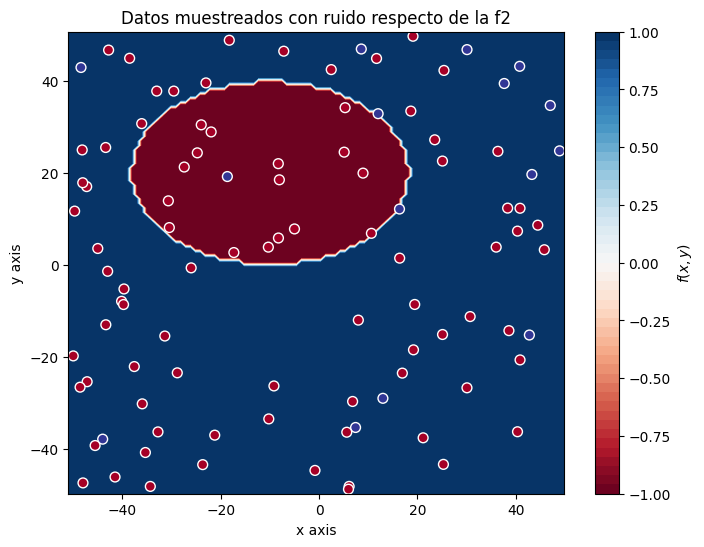

Misclassification rate: 70.0%


In [11]:
plot_datos_cuad(x, y_noise, f2, title="Datos muestreados con ruido respecto de la f2")
print('Misclassification rate: {}%'.format(MC_rate(x, y_noise, f2)))

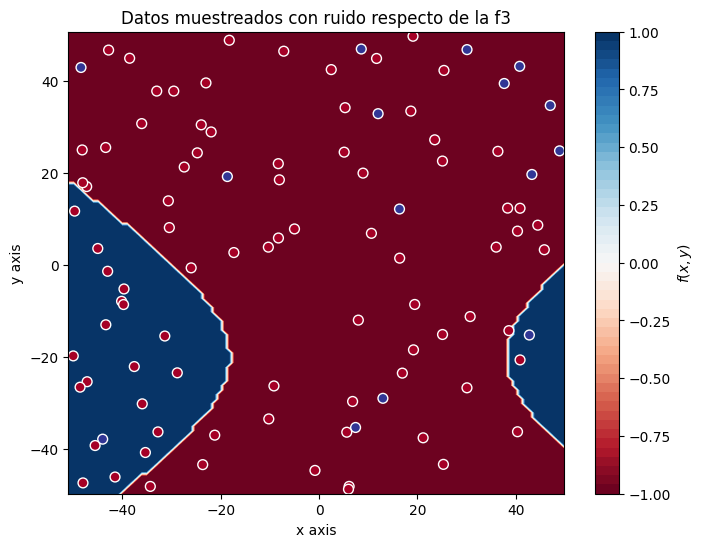

Misclassification rate: 33.0%


In [12]:
plot_datos_cuad(x, y_noise, f3, title="Datos muestreados con ruido respecto de la f3")
print('Misclassification rate: {}%'.format(MC_rate(x, y_noise, f3)))

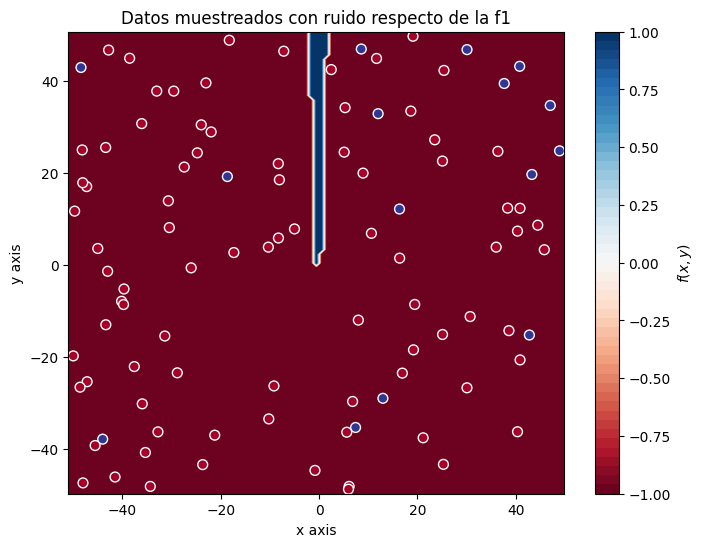

Misclassification rate: 15.0%


In [13]:
plot_datos_cuad(x, y_noise, f4, title="Datos muestreados con ruido respecto de la f1")
print('Misclassification rate: {}%'.format(MC_rate(x, y_noise, f4)))


Observando las gráficas podemos ver como para nada funcionan bien como clasificadores solo por el simple hecho de ser más complejas. En el proceso que hemos realizado no ha habido ningun tipo de aprendizaje, simplemente hemos intentado ver como clasificaba una función en base al etiquetado generado por una función lineal y posteriormente introduciendo ruido. Incluso en el mejor de los casos (si ejecutas varias veces segun la seed hay un ejemplo con mc_rate 21% que es el más bajo que he visualizado) esto es simplemente un número y nisiquiera sirve para generalizar sobre el etiquetado.
Respecto a lo de si es posible mejorar ese 10% de error, con este tipo de funciones en el mejor de los casos podriamos mejorarlo pero podría ser por simple casualidad, pero en un proceso en el que haya aprendizaje la forma de conseguirlo serían ajustando un modelo el cual tendria un overfitting muy grande y que tampoco serviría para generalizar por lo cual no es mejorable ese 10% por el simple hecho de que nosotros lo hemos introducido a mano después de generar el etiquetado a través de una función.


Si empleamos las funciones complejas para realizar el etiquetado y luego le metemos el 10% de ruido (ejemplo en la siguiente celda) pasa lo esperado, y es que la función nos arrojar un 10% de MC Rate como es normal ya que el ruido lo hemos metido manualmente.
Si nos paramos a pensar podemos darnos cuenta que para datos con ruido es muy dificil bajar a un error cercano a 0 ya que el etiquetado contiene errores. La idea a la que tenemos que llegar es que debemos buscar un clasificador el cual funcione bien para nuestro conjunto de entrenamiento y también sea bueno generalizando y es muy dificil definir a mano una función compleja que nos funcione perfectamente para un dataset que contiene ruido.

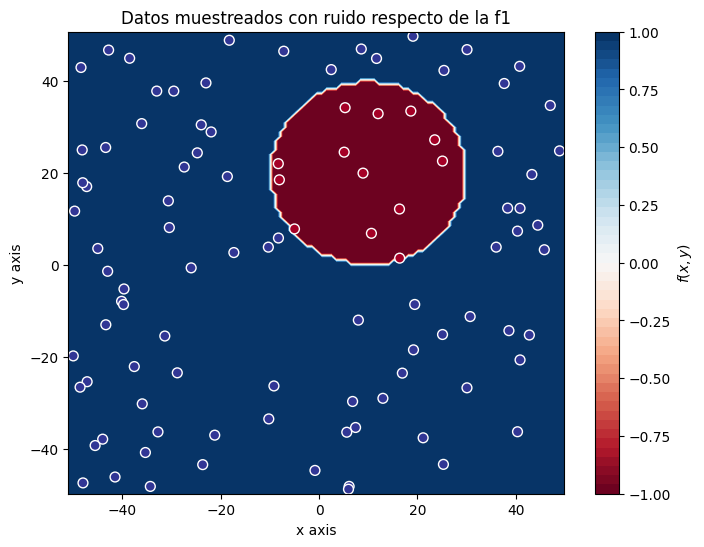

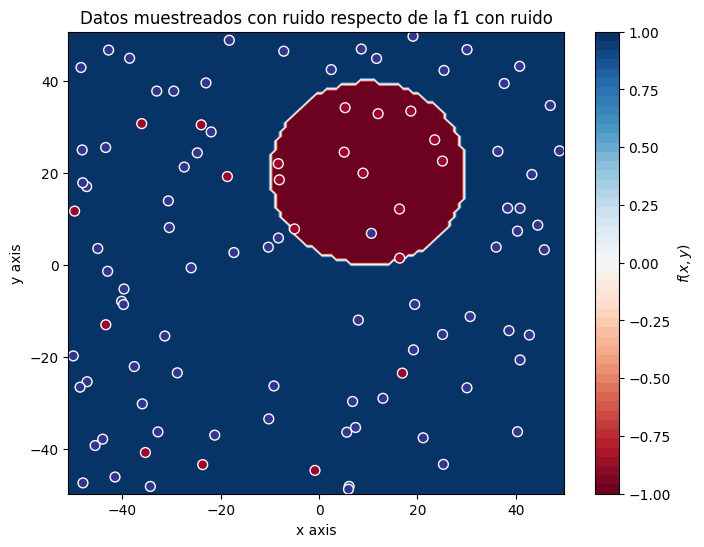

Misclassification rate: 10.0%


In [14]:
#Generamos la etiqueta que le pertenece a cada dato
y_f1 = np.array(f1(x))
y_f1[y_f1 >= 0] = 1
y_f1[y_f1 < 0] = -1

y_noise_f1 = introducir_ruido(y_f1.copy(), 0.1)
plot_datos_cuad(x, y_f1, f1, title="Datos muestreados con ruido respecto de la f1")

plot_datos_cuad(x, y_noise_f1, f1, title="Datos muestreados con ruido respecto de la f1 con ruido")
print('Misclassification rate: {}%'.format(MC_rate(x, y_noise_f1, f1)))


## <font color='blue'>Ejercicio 2: MODELOS LINEALES (8 puntos) </font>

### <font color='blue'>Apartado 2.1 (3 puntos) Algoritmo Perceptrón (PLA). 

<font color='blue'>Implementar la función $ajusta\_PLA(datos, label, max\_iter, vini)$ que calcula el hiperplano solución a un problema de clasificación binaria usando el algoritmo PLA. La entrada $datos$ es una matriz donde cada ejemplo está representado por una fila de la matriz, $label$ el vector de etiquetas (cada etiqueta es
un valor +1 o -1), $max\_iter$ es el número máximo de iteraciones permitidas y $vini$
el valor inicial del vector. La función devuelve, como mínimo, los coeficientes del hiperplano y la iteración de convergencia.  </font>



In [15]:
def ajusta_PLA(datos, label, max_iter, vini):
    changes = True
    iter = 0
    while changes == True and iter < max_iter:
      changes = False
      for i in range(datos.shape[0]):
        if signo(vini.dot(datos[i])) != label[i]:
          vini = vini + label[i] * datos[i]
          changes = True

        iter += 1
        if iter >= max_iter:
          break

    return vini, iter 

<font color='blue'>Ejecutar el algoritmo PLA con los datos empleados en el Apartado (a) del Ejercicio 1. Inicializar el algoritmo con: 

<font color='blue'>i) el vector cero y, 

<font color='blue'>ii) con vectores de
números aleatorios en [0, 1] (10 veces). 

<font color='blue'>Anotar el número medio de iteraciones
necesarias en ambos para converger. Se deben mostrar en una tabla cada uno de los pesos iniciales empleados, los finales (obtenidos tras el proceso de entrenamiento), y el porcentaje de error de clasificación. También se debe visualizar una nube de puntos etiquetada junto con la frontera resultante del ajuste. Valorar el resultado relacionando el punto
de inicio con el número de iteraciones. </font>

In [16]:
#Hace un grafico de una nube de puntos y varias rectas, siendo la primera la referente a w0, ws a 
#todos los vectores inicializados aleatoriamente y w_mean a la media de los vectores aleatorios
def plot_pla_result(x, y, w, ws, w_mean):
  # Creo unas figuras
  fig = plt.figure(figsize=(16,6))
  
  xx = np.linspace(intervalo[0], intervalo[1])

  ax1 = plt.subplot(1, 2, 1)
  ax1.set_title("Puntos muestreados")
  ax1.set_xlabel("x")
  ax1.set_ylabel("y") 
  ax1.set_ylim(intervalo)
  plt.scatter(x[:,1], x[:,2], c = y)

  wa = -w[1] / w[2]
  wyy = wa * xx - w[0] / w[2]
  plt.plot(xx, wyy, c = 'blue', label = "Recta W_0")

  for i in range(len(ws)):
    wa = -ws[i][1] / ws[i][2]
    wyy = wa * xx - ws[i][0] / ws[i][2]
    plt.plot(xx, wyy, c = 'grey', alpha=0.5)
  
  wa = -w_mean[1] / w_mean[2]
  wyy = wa * xx - w_mean[0] / w_mean[2]
  plt.plot(xx, wyy, c = 'red', label="Recta media vectores aleatorios")

  plt.legend()

# Funcion que nos sirve para calcular el MC Rate del perceptron que coincide en el PLA
# con la función de error Ein ya que ambos en este caso calculan el numero de errores
# en la clasificación
def mc_rate_pla(x, y, w):  
  y_pred = np.sum(x*w, axis=1)
  y_pred[y_pred >= 0] = 1
  y_pred[y_pred < 0] = -1
  errores = np.where((y-y_pred) != 0)
  return len(errores[0])/len(y) * 100

# Funcion que busca la recta objetivo para un conjunto utilizando un vector inicializado a 0
# 10 vectores inicializados aleatoriamente con una distribucion uniforme y muestra un grafico de los resultados
def calcula_w_iter(x, y, iteraciones_maximas):
  w = np.zeros(x.shape[1])
  w_pla, iter_pla = ajusta_PLA(x, y, iteraciones_maximas, w)

  w_new = []
  ws = []
  iterations = []

  for i in range(10):
    w = np.random.uniform(0, 1, x.shape[1])
    w_new.append(w)
    w, iter = ajusta_PLA(x, y, iteraciones_maximas, w)
    ws.append(w)
    iterations.append(iter)

  ws_mean = np.average(ws, axis=0)
  iter_mean = np.array(iterations).mean()

  table = [["", "W_inicial", "W_Final", "Iteraciones", "MC_rate"]]

  table.append(["W_0", np.zeros(x_pla.shape[1]), w_pla, iter_pla, mc_rate_pla(x, y, w_pla)])

  for i in range(len(ws)):
    table.append(["W_" + str((i+1)), w_new[i], ws[i], iterations[i], mc_rate_pla(x, y, ws[i])])

  print(tabulate(table))
  print("Media de los pesos finales para w inicial aleatorio", ws_mean)
  print("Numero de iteraciones media para w inicial aleatorio", iter_mean)     

  plot_pla_result(x, y, w_pla, ws, ws_mean)


----  ----------------------------------  ----------------------------------------------  -----------  -------
      W_inicial                           W_Final                                         Iteraciones  MC_rate
W_0   [0. 0. 0.]                          [-2129.            44.85508745    17.01070298]  44400        0.0
W_1   [0.0987434  0.65130433 0.70351699]  [-2659.9012566     56.29715141    24.47679269]  83400        0.0
W_2   [0.61024081 0.79961526 0.03457122]  [-3059.38975919    62.94089045    30.26610944]  121800       0.0
W_3   [0.77023873 0.7317286  0.25969839]  [-412.22976127    8.53964388    3.87570422]     1700         0.0
W_4   [0.2570693  0.63230332 0.34529746]  [-3424.7429307     71.18574964    31.08624278]  157300       0.0
W_5   [0.79658868 0.44614623 0.78274941]  [-3377.20341132    70.5926682     29.32890462]  152200       0.0
W_6   [0.99047178 0.30024834 0.14300583]  [-1562.00952822    32.78826344    12.54280538]  21700        0.0
W_7   [0.90130844 0.54155938 

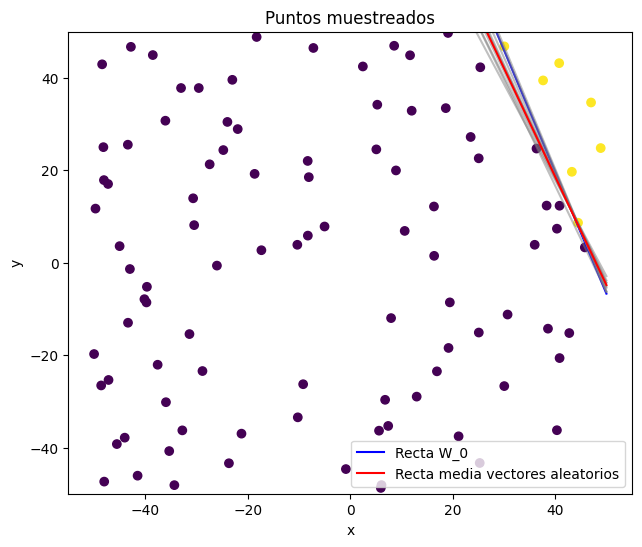

In [17]:
# Llamamos al experimento con los datos linealmente separables
y_pla = y.copy()
x_pla = np.c_[np.ones(len(x)), x]
calcula_w_iter(x_pla, y_pla, np.inf)

En el perceptrón, el vector de pesos inicial influye en la velocidad de la convergencia del modelo. En general, cuanto más cerca esté el vector de pesos inicial de los valores óptimos, más rápido convergerá el modelo. Sin embargo, el número de iteraciones necesarias para que el perceptrón converja no depende solo del vector de pesos inicial, sino también de la complejidad del problema y de la separabilidad de los datos.

En el caso de datos linealmente separables como es el caso de la celda anterior, el perceptrón siempre convergerá después de un número finito de iteraciones. En general, el número de iteraciones necesarias para la convergencia dependerá de la complejidad del problema de clasificación, la separabilidad de los datos y el tamaño del conjunto de entrenamiento.

Por lo tanto, no se puede establecer una relación precisa entre el vector de pesos inicial y el número de iteraciones necesarias para la convergencia del perceptrón, ya que también influyen otros factores.

Podemos ver en la tabla anterior que podemos a partir de pesos iniciales muy distintos llegar a pesos finales distintos en un número de iteraciones diferente y ambos consiguiendo tener un MC Rate de 0 ya que en el caso del perceptrón y con datos linealmente separables queremos encontrar la primera solución que nos separe los datos de la forma correcta y en caso de nuestro conjunto de entrenamiento que no es muy grande (en comparacion al de test que usaremos en los siguientes apartados con >999 muestras) no tiene tanta exigencia para encontrar la linea que los separa.


<font color='blue'>Ahora, hay que hacer lo mismo usando  los datos del Apartado (b) del Ejercicio 1, y $150.000$ como número máximo de iteraciones. ¿Se observa algún comportamiento diferente? En caso afirmativo, diga cuál y las
razones para que ello ocurra. </font>

----  ----------------------------------  -------------------------------------------------  -----------  ------------------
      W_inicial                           W_Final                                            Iteraciones  MC_rate
W_0   [0. 0. 0.]                          [-1172.            55.31217737    -3.25335011]     150000       26.0
W_1   [0.03039969 0.3665431  0.86234625]  [-1161.96960031    61.0120841    -13.7425557 ]     150000       26.0
W_2   [0.69267772 0.69094214 0.1886368 ]  [-1161.30732228    61.02156281    -6.38318098]     150000       28.999999999999996
W_3   [0.44190428 0.58157741 0.98975171]  [-1165.55809572    45.27840249    -9.70566385]     150000       24.0
W_4   [0.20390623 0.2477329  0.26217308]  [-1153.79609377    39.61459562    -6.44649076]     150000       22.0
W_5   [0.75017241 0.45697533 0.05692944]  [-1148.24982759    57.90826436   -18.90617864]     150000       28.000000000000004
W_6   [0.50851624 0.21196016 0.79860424]  [-1165.49148376    49.300

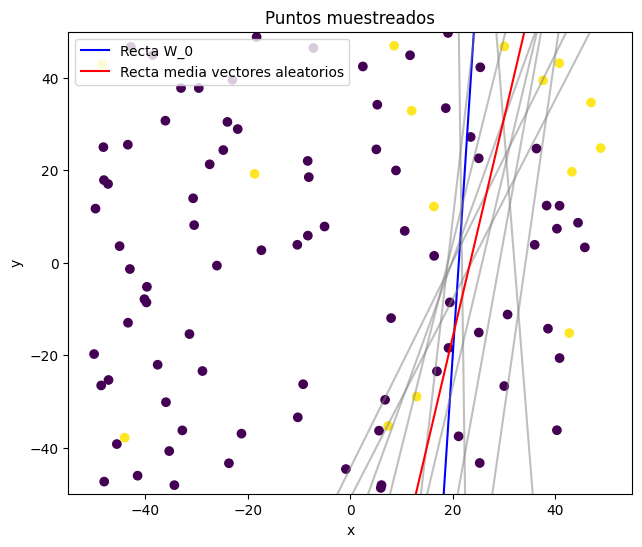

In [18]:
# Llamamos al experimento con los datos no linealmente separables
# las rectas grises con las rectas formadas por cada uno de los vectores inicializados aleatoriamente y
# la recta roja es la media de todos esos vectores
y_b = y_noise
x_b = np.c_[np.ones(len(x)), x]
calcula_w_iter(x_b.copy(), y_b.copy(), 150000)

Ahora ya en este caso con datos no linealmente separables vemos que todas las ejecuciones del perceptron llegan a agotar el numero maximo de iteraciones establecido ya que no son capaces de encontrar una solución para separar los datos y estamos alterando continuamente con cada iteración el valor de nuestro vector de pesos esto hace que no llegue a converger y que este constantemente divergiendo. (El PLA solo es bueno para datos linealmente separables debido a la naturaleza del algoritmo W2*X2 + W1*X1 + W0 )

### <font color='blue'>Apartado 2.2 (5 puntos) Regresión Logística (RL). 


<font color='blue'>En este ejercicio emplearemos nuestra propia función
objetivo $f$ y un conjunto de datos $\mathcal{D}$ para ver cómo
funciona regresión logística. Consideraremos $d = 2$ para que los datos sean fácilmente visualizables, y emplearemos $\mathcal{X} = [0, 2] \times [0, 2]$ con
probabilidad uniforme de elegir cada $x \in \mathcal{X}$. Elegir una línea en el plano que pase por
$\mathcal{X}$ como la frontera que separa la región en donde $y$ toma valores +1 y -1. Para ello, seleccionar dos puntos aleatorios de $\mathcal{X}$ y calcular la línea
que pasa por ambos. 

<font color='blue'>Impleméntese RL con Gradiente Descendente Estocástico (SGD) del siguiente modo:

> <font color='blue'>1) Inicializar el vector de pesos con valores 0.

> <font color='blue'>2) Parar el algoritmo cuando $\|w^{(t+1)} - w^{(t)}\| < 0.01$, donde $w(t)$ denota el vector
de pesos al final de la época $t$. Recuérdese que una época es un pase completo a través de los $N$
ejemplos de nuestro conjunto de datos.

> <font color='blue'>3) Aplicar una permutación aleatoria de $\{1, 2,..., N\}$ a los índices de los datos, antes
de usarlos en cada época del algoritmo.

</font>


In [19]:
# Funcion gradiente de la RL
def grad_rl(w,x,y):
  numerador = y.reshape(-1,1) * x
  denominador = 1 + np.e**(y * np.dot(x, w.T))
  resultado = numerador/denominador.reshape(-1,1)
  sum = np.sum( (-1/x.shape[0]) * resultado,axis=0)
  return sum

# Funcion de error de la RL
def ein_rl(w, x, y):
  resultado = 1 + np.e**(-y * np.dot(x, w.T))
  sum = np.sum(np.log(resultado))
  return sum/x.shape[0]

# Algoritmo RL
def sgdRL(x, y, lr, tam_minibatch, max_epocas, w_ini, plot_grad = 0, condicion_parada = 0):
  w = []
  w.append(w_ini)
  iter = 0;
  graf = []
  for i in range(max_epocas):
    
    indexes = np.arange(0, x.shape[0])
    random.shuffle(indexes)

    grad = grad_rl(w[i], x[indexes[0:tam_minibatch]], y[indexes[0:tam_minibatch]])
    w.append(w[i] - lr * grad)
    graf.append(mc_rate_pla(x, y, w[i]))

    iter += 1
    if condicion_parada == 0:
      if (abs(w[i+1] - w[i])).sum() < 0.01:
          break
  
  if plot_grad == 1:
    plt.figure()
    plt.title("MC Rate con el avance de las iteraciones")
    plt.plot(range(0,len(graf)), graf, '-bo')
    plt.xlabel('Iteraciones')
    plt.ylabel('Valor de MC Rate')
    plt.ylim([0, max(graf)])
    plt.show()  

  return w[len(w) - 1], iter

intervalo = [0,2]  

<font color='blue'>A continuación, empleando la implementación anterior, realícese el siguiente experimento:
 
> <font color='blue'>1) Seleccione $N = 100$ puntos aleatorios $\{{\bf x}_n \}$ de $\mathcal{X}$ y evalúe las
respuestas $\{y_n\}$ de todos ellos respecto de la frontera elegida. 

> <font color='blue'>2) Ejecute RL para encontrar la función solución $g$. Visualice la frontera de decisión encontrada, y muestre el $E_{in}$ y el porcentaje de acierto en clasificación correspondientes. Se debe escoger experimentalmente tanto el $\textit{learning rate}$ (tasa de aprendizaje $\eta$) como el tamaño de batch. 

> <font color='blue'>3) Evalúe el error $E_{out}$ usando para ello una nueva muestra de datos ($>999$).  Muéstrense, de nuevo, tanto el ajuste visual, como el $E_{out}$ y el porcentaje de acierto en test. 

> <font color='blue'>4) Repita el experimento anterior (pasos 1-3) $50$ veces, y calcule los valores promedio de $E_{in}$ y $E_{out}$, de porcentaje de error de clasificación (en entrenamiento y test), y de épocas necesarias para converger (en entrenamiento).   

<font color='blue'>Junto con la realización del experimento anteriormente descrito, discuta qué ocurriría si, como criterio de parada, se emplease la diferencia entre pesos obtenidos en sucesivas iteraciones (en lugar de en sucesivas épocas). Del mismo modo, explique cómo ha escogido el $\textit{learning rate}$ y el $\textit{batch size}$, y las conclusiones que extrae al respecto (por ejemplo, ¿valores de $\textit{learning rate}$ como 0.001, cuando se emplea la diferencia de pesos entre épocas como criterio de terminación, funcionan adecuadamente y permiten resolver el problema?). 




In [20]:
# Funcion que nos permite visualizar dos graficos uno para train y otro para test y las lineas de etiquetado y las conseguidas por el algoritmo
def plot_graf_line_w(intervalo, x, y, x_test, y_test, w, lin_values):
  fig = plt.figure(figsize=(16,6))

  xx = np.linspace(intervalo[0], intervalo[1], num=100)

  ax1 = plt.subplot(1, 2, 1)
  ax1.set_title("Puntos muestreados train")
  ax1.set_xlabel("x")
  ax1.set_ylabel("y") 
  ax1.set_ylim(intervalo)
  plt.scatter(x[:,1], x[:,2], c = y)

  wa = -w[1] / w[2]
  wyy = (wa * xx) - (w[0] / w[2])
  plt.plot(xx, wyy, c = 'blue', label = "Recta W")


  xx = np.linspace(intervalo[0], intervalo[1], num=100)
  yy = lin_values[0] * xx + lin_values[1]
  plt.plot(xx, yy, c = 'red', label="Recta F")

  plt.legend()

  ax2 = plt.subplot(1, 2, 2)
  ax2.set_title("Puntos muestreados test")
  ax2.set_xlabel("x")
  ax2.set_ylabel("y") 
  ax2.set_ylim(intervalo)
  plt.scatter(x_test[:,1], x_test[:,2], c = y_test)

  wa = -w[1] / w[2]
  wyy = wa * xx - w[0] / w[2]
  plt.plot(xx, wyy, c = 'blue', label = "Recta W")


  xx = np.linspace(intervalo[0], intervalo[1], num=100)
  yy = lin_values[0] * xx + lin_values[1]
  plt.plot(xx, yy, c = 'red', label="Recta F")

  plt.legend()


In [21]:
x, y, x_test, y_test, lin_values = get_data_set(intervalo, 0)

A continuacion ejecuto los experimentos para LR 1, 0.1, 0.01, 0.001 y luego el que mejor me ha funcionado a mi

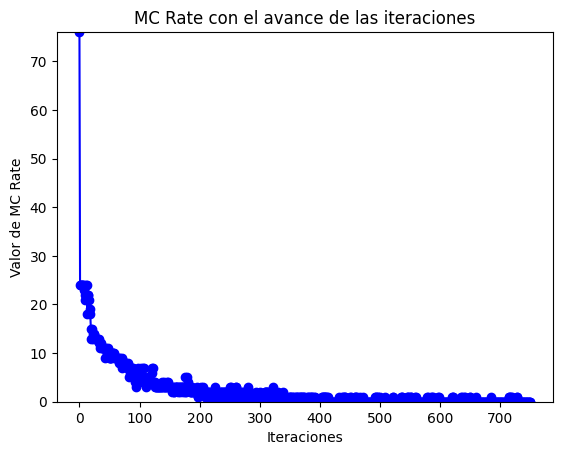

W: [-12.16630768   2.94033931   6.47211094]
MC_rate: 0.0 %
MC_rate_out: 6.506506506506507 %
Ein: 0.0938364489936362
Eout: 0.1645025878482601
Iteraciones: 751


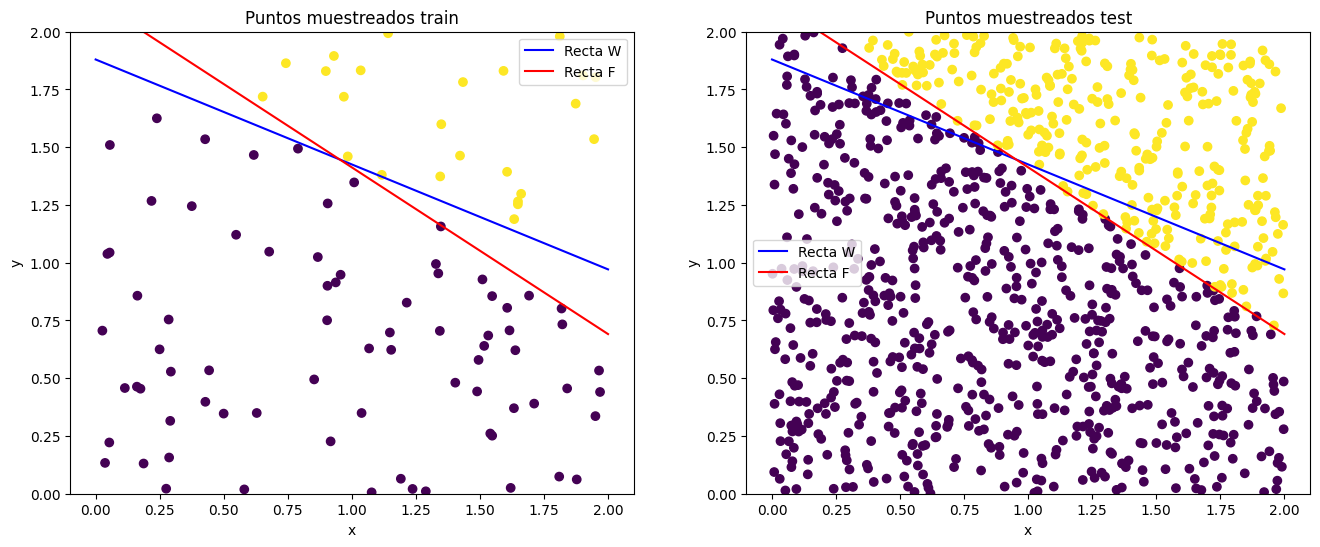

In [22]:
w, iter = sgdRL(x, y, 1, 64, 5000, np.zeros(x.shape[1]), 1)

mc_rate_in = mc_rate_pla(x, y, w)
mc_rate_out = mc_rate_pla(x_test, y_test, w)

ein = ein_rl(w,x,y)
eout = ein_rl(w,x_test,y_test)

print("W:", w)
print("MC_rate:",  mc_rate_in, "%")
print("MC_rate_out:",  mc_rate_out, "%")
print("Ein:",  ein)
print("Eout:",  eout)
print("Iteraciones:",  iter)

#### Gráfico
plot_graf_line_w(intervalo, x, y, x_test, y_test, w, lin_values)

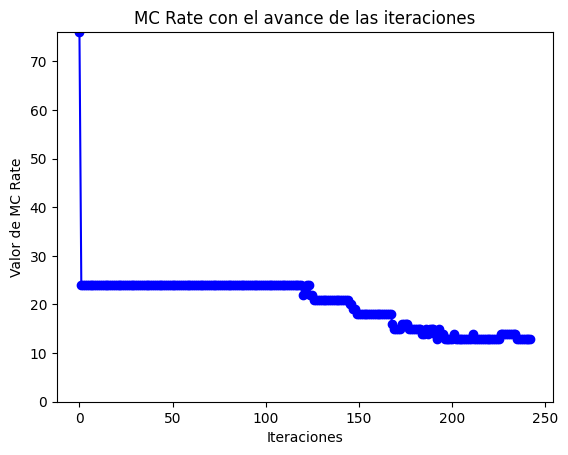

W: [-2.05397724 -0.10695083  1.38888171]
MC_rate: 13.0 %
MC_rate_out: 21.02102102102102 %
Ein: 0.3777354231160374
Eout: 0.46129905619088507
Iteraciones: 243


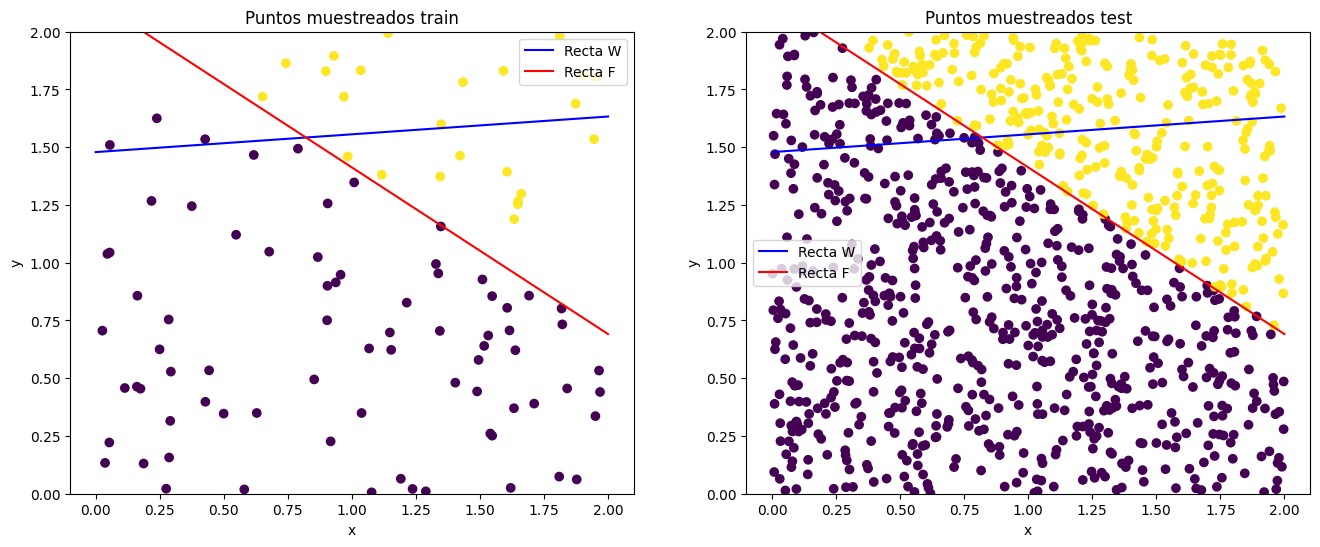

In [23]:
w, iter = sgdRL(x, y, 0.1, 64, 5000, np.zeros(x.shape[1]), 1)

mc_rate_in = mc_rate_pla(x, y, w)
mc_rate_out = mc_rate_pla(x_test, y_test, w)

ein = ein_rl(w,x,y)
eout = ein_rl(w,x_test,y_test)

print("W:", w)
print("MC_rate:",  mc_rate_in, "%")
print("MC_rate_out:",  mc_rate_out, "%")
print("Ein:",  ein)
print("Eout:",  eout)
print("Iteraciones:",  iter)

#### Gráfico
plot_graf_line_w(intervalo, x, y, x_test, y_test, w, lin_values)

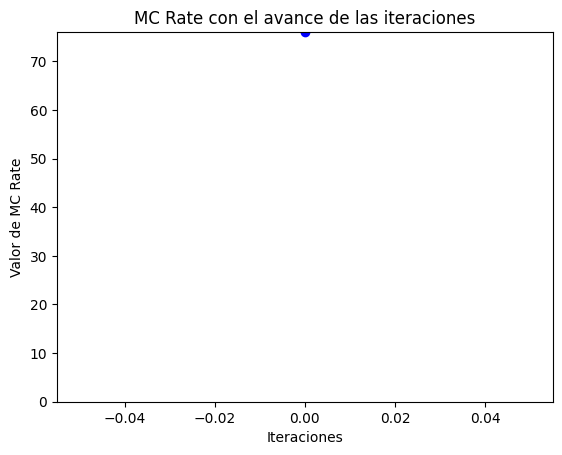

W: [-2.03125000e-03 -1.13265696e-03  8.02661545e-05]
MC_rate: 24.0 %
MC_rate_out: 31.33133133133133 %
Ein: 0.6923972948388908
Eout: 0.6926845800844359
Iteraciones: 1


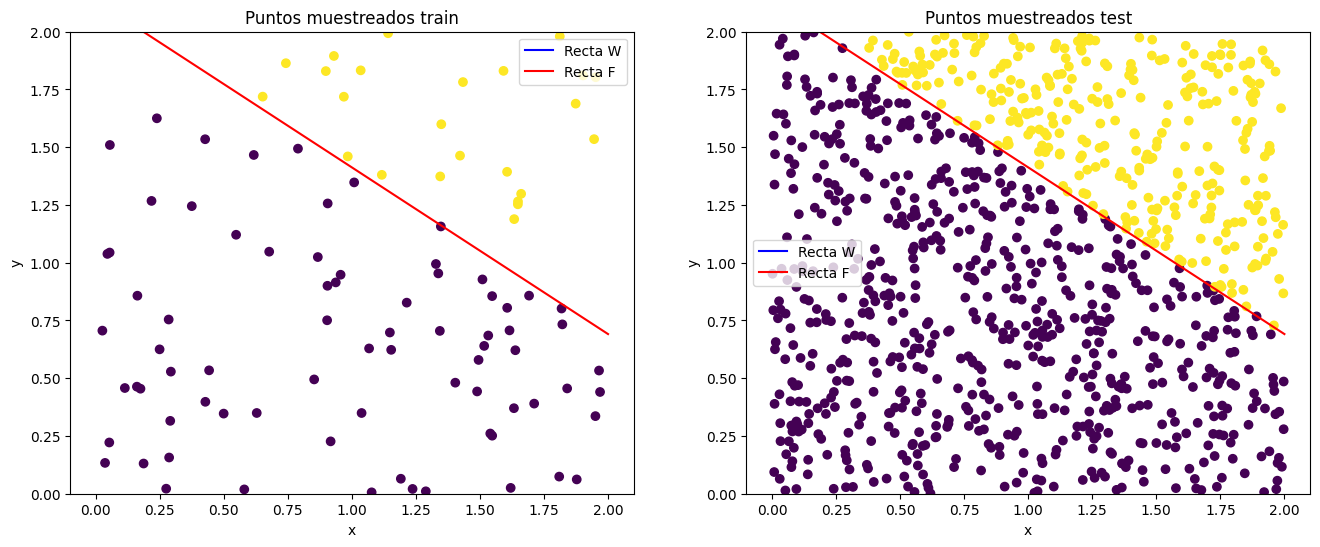

In [24]:
w, iter = sgdRL(x, y, 0.01, 64, 5000, np.zeros(x.shape[1]), 1)

mc_rate_in = mc_rate_pla(x, y, w)
mc_rate_out = mc_rate_pla(x_test, y_test, w)

ein = ein_rl(w,x,y)
eout = ein_rl(w,x_test,y_test)

print("W:", w)
print("MC_rate:",  mc_rate_in, "%")
print("MC_rate_out:",  mc_rate_out, "%")
print("Ein:",  ein)
print("Eout:",  eout)
print("Iteraciones:",  iter)

#### Gráfico
plot_graf_line_w(intervalo, x, y, x_test, y_test, w, lin_values)

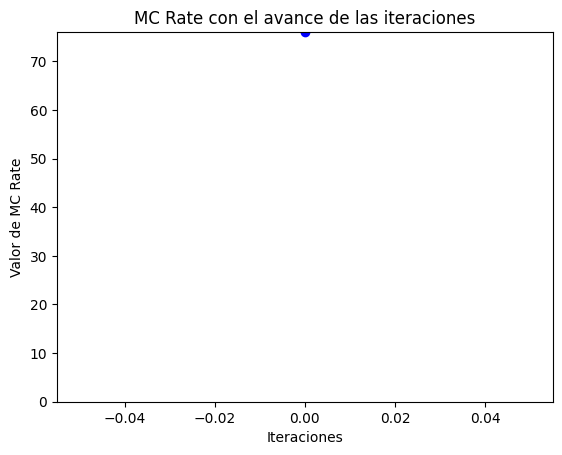

W: [-2.81250000e-04 -2.24271050e-04 -8.82075266e-05]
MC_rate: 24.0 %
MC_rate_out: 31.33133133133133 %
Ein: 0.6930246523770708
Eout: 0.6930762513886366
Iteraciones: 1


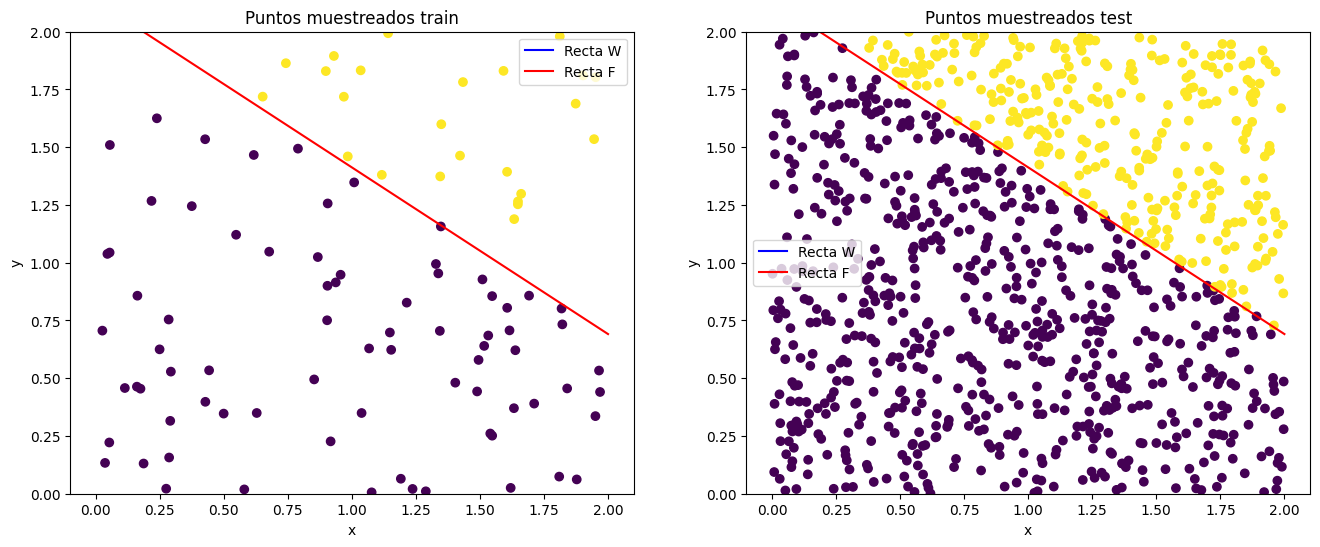

In [25]:
w, iter = sgdRL(x, y, 0.001, 64, 5000, np.zeros(x.shape[1]), 1)

mc_rate_in = mc_rate_pla(x, y, w)
mc_rate_out = mc_rate_pla(x_test, y_test, w)

ein = ein_rl(w,x,y)
eout = ein_rl(w,x_test,y_test)

print("W:", w)
print("MC_rate:",  mc_rate_in, "%")
print("MC_rate_out:",  mc_rate_out, "%")
print("Ein:",  ein)
print("Eout:",  eout)
print("Iteraciones:",  iter)

#### Gráfico
plot_graf_line_w(intervalo, x, y, x_test, y_test, w, lin_values)

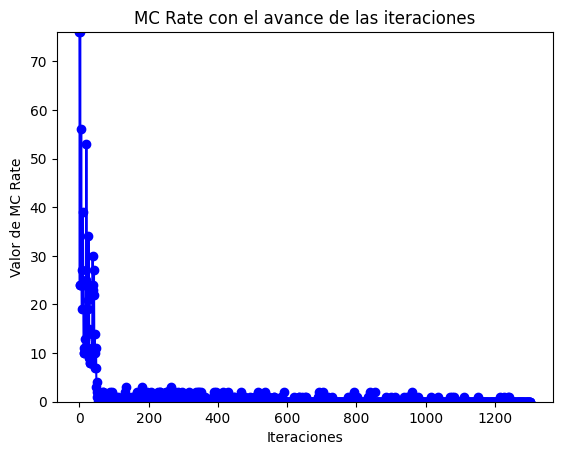

W: [-58.21127172  16.46655424  29.82907438]
MC_rate: 0.0 %
MC_rate_out: 3.903903903903904 %
Ein: 0.013650058819777712
Eout: 0.08641530920461563
Iteraciones: 1304


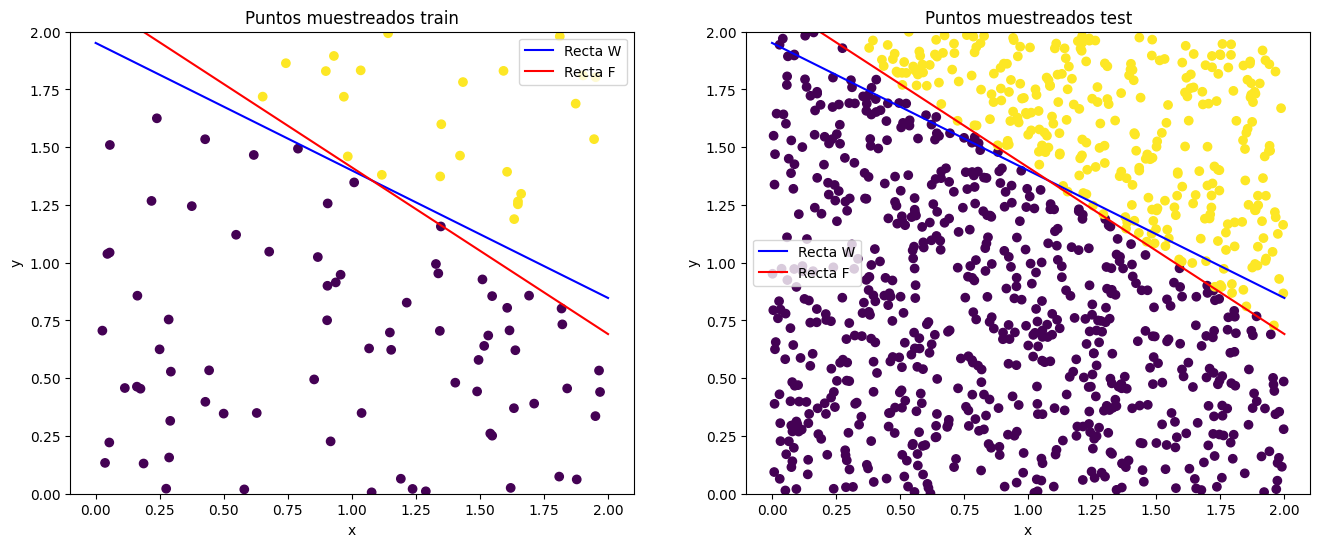

In [26]:
w, iter = sgdRL(x, y, 30, 64, 5000, np.zeros(x.shape[1]), 1)

mc_rate_in = mc_rate_pla(x, y, w)
mc_rate_out = mc_rate_pla(x_test, y_test, w)

ein = ein_rl(w,x,y)
eout = ein_rl(w,x_test,y_test)

print("W:", w)
print("MC_rate:",  mc_rate_in, "%")
print("MC_rate_out:",  mc_rate_out, "%")
print("Ein:",  ein)
print("Eout:",  eout)
print("Iteraciones:",  iter)

#### Gráfico
plot_graf_line_w(intervalo, x, y, x_test, y_test, w, lin_values)

In [27]:
mc_rate_in_med = []
mc_rate_out_med = []
ein_med = []
eout_med = []
iter_med = []

for index in range(50):

  x, y, x_test, y_test, lin_values = get_data_set(intervalo, 0)
  w, iter = sgdRL(x, y, 32, 64, 5000, np.zeros(x.shape[1]))

  mc_rate_in = mc_rate_pla(x, y, w)
  mc_rate_out = mc_rate_pla(x_test, y_test, w)
  ein = ein_rl(w,x,y)
  eout = ein_rl(w,x_test,y_test)

  mc_rate_in_med.append(mc_rate_in)
  mc_rate_out_med.append(mc_rate_out)
  ein_med.append(ein)
  eout_med.append(eout)
  iter_med.append(iter)


print("MC rate EIN medio ", np.array(mc_rate_in_med).mean())
print("MC rate EOUT medio ", np.array(mc_rate_out_med).mean())
print("Ein medio ", abs(np.array(ein_med).mean()))
print("Eout medio ", abs(np.array(eout_med).mean()))
print("Epocas medias para converger ", np.array(iter_med).mean())



MC rate EIN medio  0.24
MC rate EOUT medio  0.9929929929929929
Ein medio  0.012724142504702395
Eout medio  0.025299703580061044
Epocas medias para converger  2948.12


Lo que pasaría si el criterio de parada fuese entre iteraciones es que podriamos salirnos en la segunda iteración si el learning rate es lo suficientemente pequeño como para cambiar muy poco el vector W lo que causaría un aprendizaje pobre.
El learning rate y el batch size los he ido consiguiendo tras varias ejecuciones de prueba y error pero no siempre el learning rate que escojo o el batch size es el mejor para cada problema. Hay problemas que dependiendo de la linea de etiquetado de los datos tarda más en llegar a converger por lo cual puede que necesite un learning rate más alto. Lo mismo se puede aplicar para el batch size ya que cuanto más pequeño sea menos estaremos aprendiendo en cada época pero cuanto más grande sea más tenderemos a caer en el overfitting.
Un learning rate pequeño para la diferencia de pesos entre épocas no es muy útil por lo mencionado anteriormente y es que al ser tan pequeño puede que la modificación de los pesos sea tan pequeña que nos salgamos del algoritmo por la condición de parada pero que el aprendizaje realizado sea completamente nulo y no sirva para nada.
Como podemos ver en la funcion que nos muestra el balance del MC Rate vemos que para learning rates muy pequeños los cambios en los pesos son tan minimos que nos salimos del algoritmo y no aprendemos nada. Al final el uso de un learning rate para este tipo de problemas viene dado para disminuir el tiempo que se tarda en llegar a un Ein bajo debido a que usamos los pesos en el exponente de un denominador dandor lugar asi a una convergencia más rápida con learning rates más altos

<font color='blue'>Ahora repita el mismo experimento, pero empleando datos no linealmente separables. Para ello, debe introducirse un 10% de ruido por clase. 

In [28]:
x, y, x_test, y_test, lin_values = get_data_set(intervalo, 1)

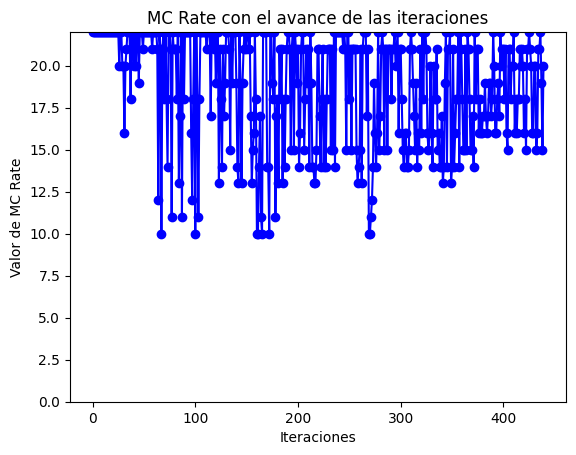

W: [ 3.8261967  -1.78930384 -0.32927321]
MC_rate: 20.0 %
MC_rate_out: 18.61861861861862 %
Ein: 0.44458367156541906
Eout: 0.4366702965953467
Iteraciones: 440


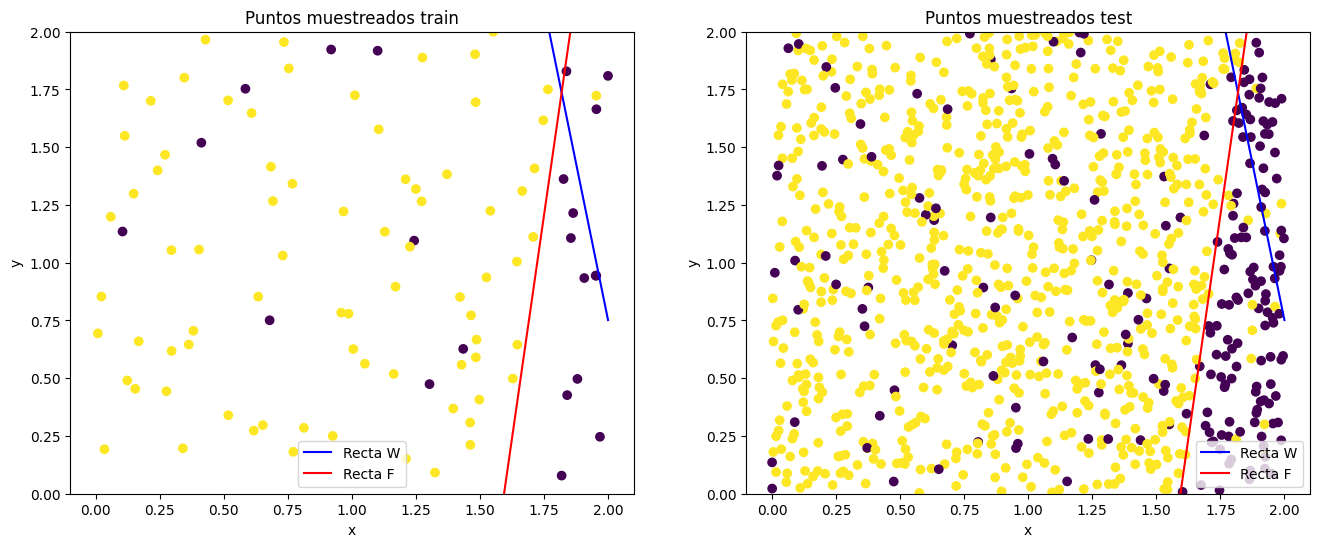

In [29]:
w, iter = sgdRL(x, y, 1, 32, 5000, np.zeros(x.shape[1]), 1)

mc_rate_in = mc_rate_pla(x, y, w)
mc_rate_out = mc_rate_pla(x_test, y_test, w)
ein = ein_rl(w,x,y)
eout = ein_rl(w,x_test,y_test)

print("W:", w)
print("MC_rate:",  mc_rate_in, "%")
print("MC_rate_out:",  mc_rate_out, "%")
print("Ein:",  ein)
print("Eout:",  eout)
print("Iteraciones:",  iter)


#### Gráfico
plot_graf_line_w(intervalo, x, y, x_test, y_test, w, lin_values)

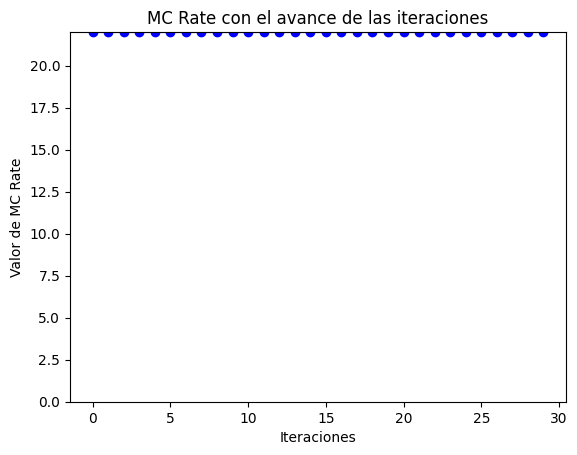

W: [0.40922023 0.11142079 0.29685036]
MC_rate: 22.0 %
MC_rate_out: 21.02102102102102 %
Ein: 0.5629056463462032
Eout: 0.5466859211400582
Iteraciones: 30


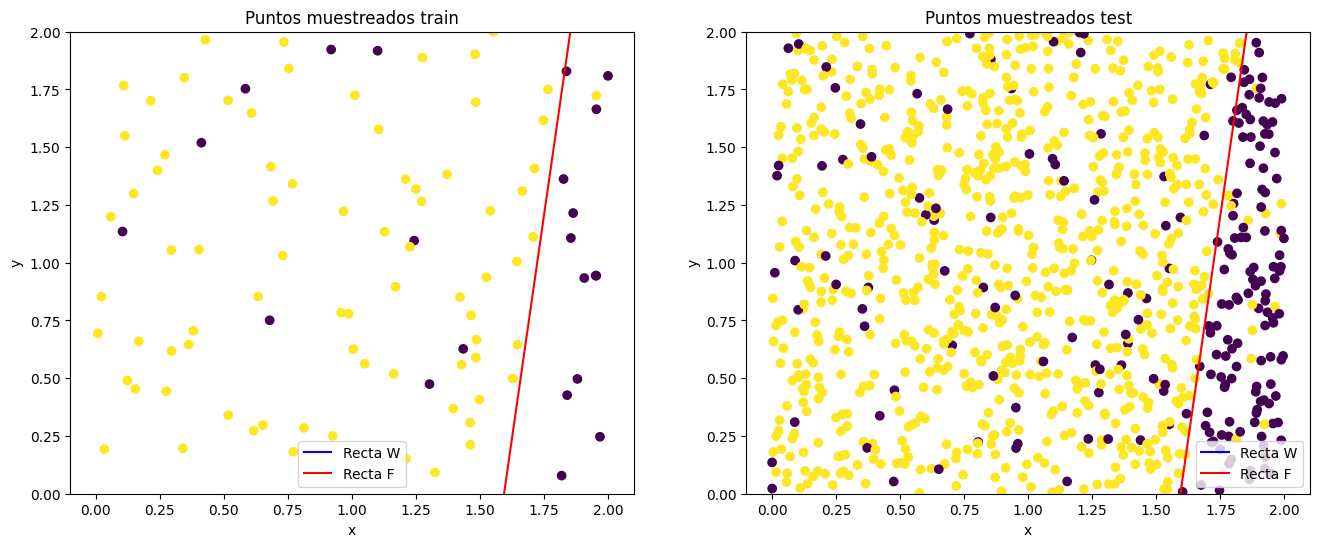

In [30]:
w, iter = sgdRL(x, y, 0.1, 32, 5000, np.zeros(x.shape[1]), 1)

mc_rate_in = mc_rate_pla(x, y, w)
mc_rate_out = mc_rate_pla(x_test, y_test, w)
ein = ein_rl(w,x,y)
eout = ein_rl(w,x_test,y_test)

print("W:", w)
print("MC_rate:",  mc_rate_in, "%")
print("MC_rate_out:",  mc_rate_out, "%")
print("Ein:",  ein)
print("Eout:",  eout)
print("Iteraciones:",  iter)


#### Gráfico
plot_graf_line_w(intervalo, x, y, x_test, y_test, w, lin_values)

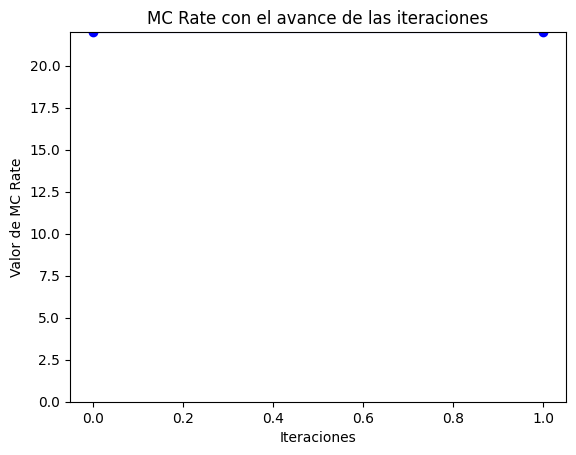

W: [0.00715613 0.0060037  0.00729107]
MC_rate: 22.0 %
MC_rate_out: 21.02102102102102 %
Ein: 0.6880232982403295
Eout: 0.6876869729008377
Iteraciones: 2


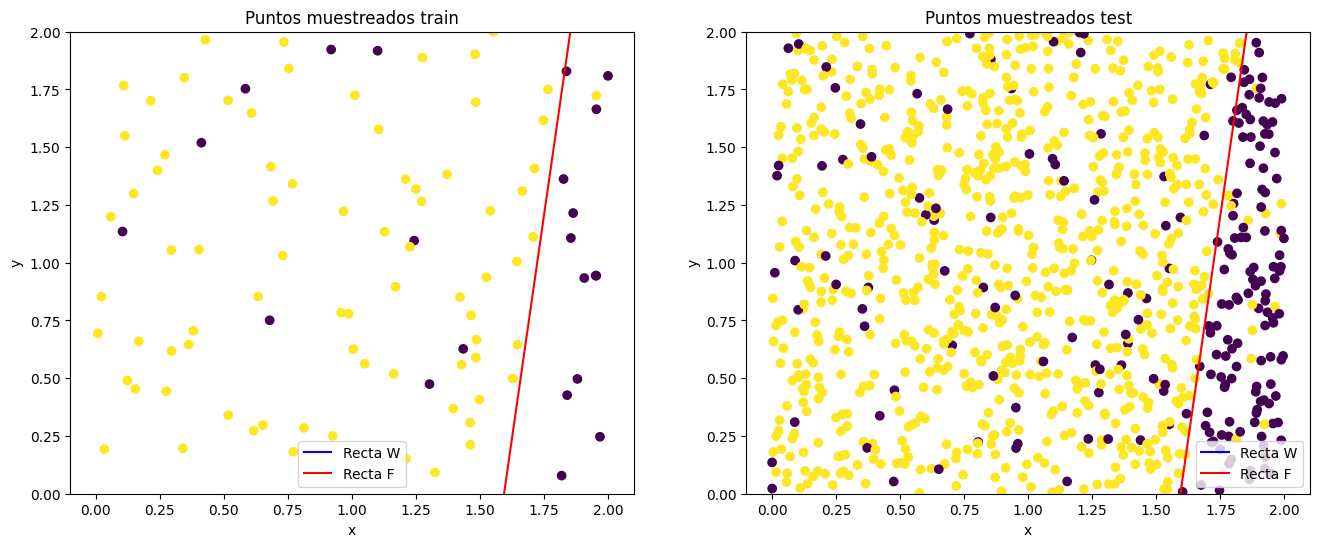

In [31]:
w, iter = sgdRL(x, y, 0.01, 32, 5000,np.zeros(x.shape[1]), 1)

mc_rate_in = mc_rate_pla(x, y, w)
mc_rate_out = mc_rate_pla(x_test, y_test, w)
ein = ein_rl(w,x,y)
eout = ein_rl(w,x_test,y_test)

print("W:", w)
print("MC_rate:",  mc_rate_in, "%")
print("MC_rate_out:",  mc_rate_out, "%")
print("Ein:",  ein)
print("Eout:",  eout)
print("Iteraciones:",  iter)


#### Gráfico
plot_graf_line_w(intervalo, x, y, x_test, y_test, w, lin_values)

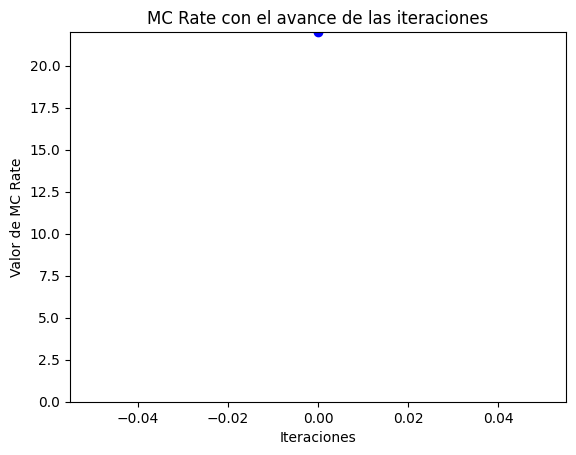

W: [0.00025    0.00018727 0.00021702]
MC_rate: 22.0 %
MC_rate_out: 21.02102102102102 %
Ein: 0.6929809253714312
Eout: 0.6929705530376093
Iteraciones: 1


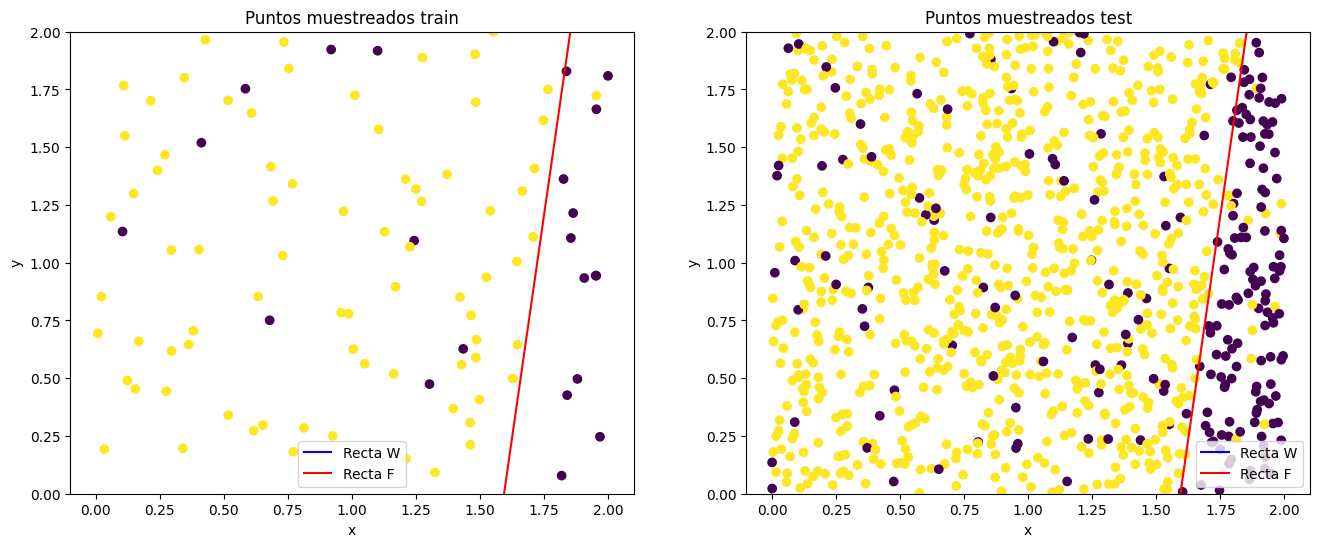

In [32]:
w, iter = sgdRL(x, y, 0.001, 32, 5000, np.zeros(x.shape[1]), 1)

mc_rate_in = mc_rate_pla(x, y, w)
mc_rate_out = mc_rate_pla(x_test, y_test, w)
ein = ein_rl(w,x,y)
eout = ein_rl(w,x_test,y_test)

print("W:", w)
print("MC_rate:",  mc_rate_in, "%")
print("MC_rate_out:",  mc_rate_out, "%")
print("Ein:",  ein)
print("Eout:",  eout)
print("Iteraciones:",  iter)


#### Gráfico
plot_graf_line_w(intervalo, x, y, x_test, y_test, w, lin_values)

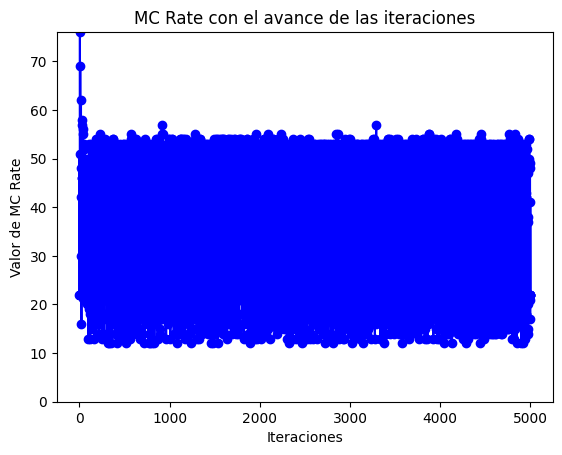

W: [ 29.20909259 -15.5129327   -1.41589452]
MC_rate: 14.000000000000002 %
MC_rate_out: 14.414414414414415 %
Ein: 1.369109697216348
Eout: 1.3369953641447108


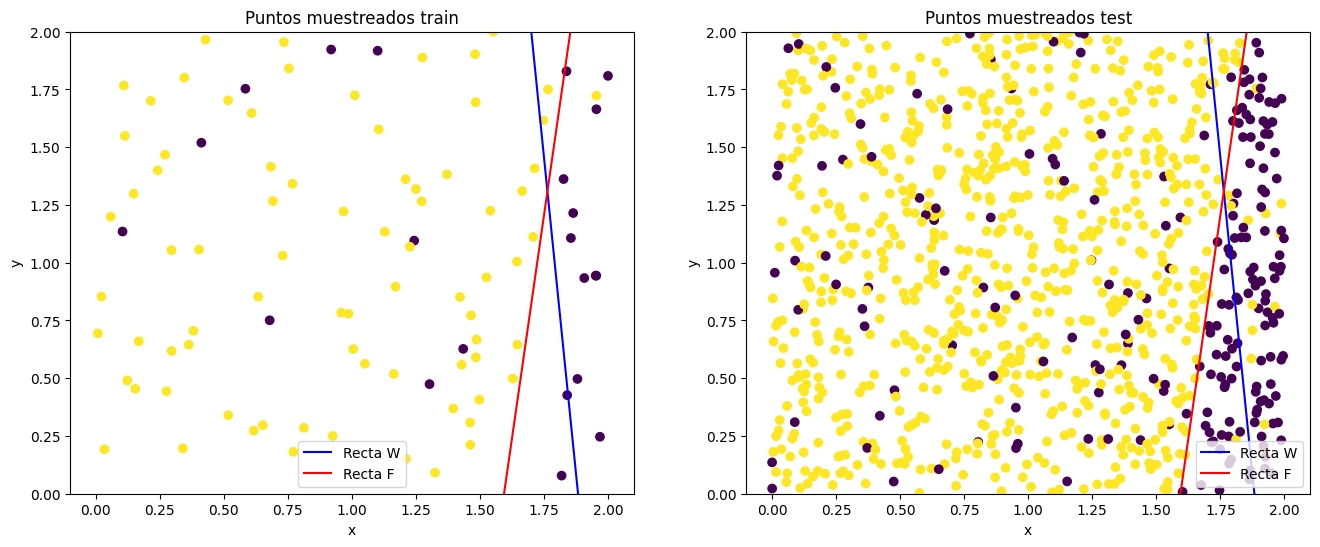

In [33]:

w, iter = sgdRL(x, y, 30, 100, 5000, np.zeros(x.shape[1]), 1)

mc_rate_in = mc_rate_pla(x, y, w)
mc_rate_out = mc_rate_pla(x_test, y_test, w)
ein = ein_rl(w,x,y)
eout = ein_rl(w,x_test,y_test)

print("W:", w)
print("MC_rate:",  mc_rate_in, "%")
print("MC_rate_out:",  mc_rate_out, "%")
print("Ein:",  ein)
print("Eout:",  eout)


#### Gráfico
plot_graf_line_w(intervalo, x, y, x_test, y_test, w, lin_values)


In [34]:

mc_rate_in_med = []
mc_rate_out_med = []
ein_med = []
eout_med = []
iter_med = []

for index in range(50):

  x, y, x_test, y_test, lin_values = get_data_set(intervalo, 1)
  w, iter = sgdRL(x, y, 7, 32, 5000, np.zeros(x.shape[1]))

  mc_rate_in = mc_rate_pla(x, y, w)
  mc_rate_out = mc_rate_pla(x_test, y_test, w)
  ein = ein_rl(w,x,y)
  eout = ein_rl(w,x_test,y_test)

  mc_rate_in_med.append(mc_rate_in)
  mc_rate_out_med.append(mc_rate_out)
  ein_med.append(ein)
  eout_med.append(eout)
  iter_med.append(iter)


print("MC rate EIN medio ", np.array(mc_rate_in_med).mean())
print("MC rate EOUT medio ", np.array(mc_rate_out_med).mean())
print("Ein medio ", abs(np.array(ein_med).mean()))
print("Eout medio ", abs(np.array(eout_med).mean()))
print("Epocas medias para converger ", np.array(iter_med).mean())


MC rate EIN medio  22.0
MC rate EOUT medio  23.673673673673676
Ein medio  0.7486424466305511
Eout medio  0.798833538612931
Epocas medias para converger  4982.72


Como podemos ver cuando hay ruido todo se complica un poco más, es más dificil llegar a conseguir esa función que solo tiene un 10% de MC Rate y tarda muchísimas más iteraciones para conseguir un resultado que puede no ser el más óptimo. De igual forma tras ejecutar con ruido varios problema sobre la misma distribución pero con diferente linea de etiquetado vemos que el error el mucho más alto que sin ruido y que Eout > Ein -- MCRateOut > MCRateIN por lo que podemos ver que con presencia de ruido en un problema siempre todo se vuelve más difícil

Una reflexion final referente a la oscilacion del MC Rate es que en muchos casos hace que oscile en un intervalo cercano a 0 ya que como usamos un learning rate tan alto el cambio en los pesos se ve afectado bastante y por eso no escapa en la condición de parada por eso va rondando el valor hasta que llega a el y no sale antes



---

## <font color='blue'> Bonus (1.5 puntos). Clasificación de dígitos.

El BONUS solo se tendrá en cuenta si se ha obtenido al menos el 75\% de los puntos de la
parte obligatoria.</font>

<font color='blue'>Considerar el conjunto de datos de dígitos manuscritos, y seleccionar las muestras de los dígitos 4 y 8. Extraer las características de intensidad promedio y simetría en la manera que se indicó en la práctica anterior.
</font>

<font color='blue'> 1) Plantear un problema de clasificación binaria que considere el conjunto de entrenamiento
como datos de entrada para aprender la función $g$.

<font color='blue'> 2) Compárense los modelos de regresión lineal, PLA, RL y PLA-Pocket. 

> <font color='blue'> a) Generar gráficos separados de los datos de entrenamiento y test junto con
la función estimada.

> <font color='blue'> b) Calcular $E_{in}$ y $E_{test}$ (error sobre los datos de test).

> <font color='blue'> c) Si se emplean los pesos obtenidos con regresión lineal para inicializar los otros tres métodos (RL, PLA, PLA-pocket), ¿se observa alguna mejora en los resultados a algún nivel? Justifique su respuesta.

> <font color='blue'> d) Obtener cotas sobre el verdadero valor de $E_{out}$ para los cuatro métodos empleados. Calcúlense dos cotas: una
basada en $E_{in}$ y otra basada en $E_{test}$. Usar una tolerancia $\delta = 0.05$. ¿Qué cota es
mejor? Justifique la respuesta.  


In [35]:
#Para acceder a nuestros ficheros de Google Drive
from google.colab import drive
drive.mount('/content/drive')
# La carpeta datos (que contiene X_train.npy, y_train.npy, X_test.npy y y_test.npy) 
# debe estar en vuestro Drive, dentro de la carpeta 'Colab Notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# Funcion para leer los datos
def readData(file_x, file_y, class1, class2, label_class1, label_class2):
    # Leemos los ficheros    
    datax = np.load(file_x)
    datay = np.load(file_y)
    y = []
    x = []    
    # Solo guardamos los datos de las dos clases que nos interesan
    for i in range(0,datay.size):
        if datay[i] == class1 or datay[i] == class2:
            if datay[i] == class1:
                y.append(label_class1)
            else:
                y.append(label_class2)
            x.append(np.array([1, datax[i][0], datax[i][1]]))
            
    x = np.array(x, np.float64)
    y = np.array(y, np.float64)
    
    return x, y

In [37]:
class1 = 8 #dígito 8
class2 = 4 #dígito 4
label1 = 1 #etiqueta empleada para representar class1
label2 = -1 #etiqueta empleada para representar class2
# Lectura de los datos de entrenamiento 
x, y = readData('drive/MyDrive/Colab Notebooks/datos/X_train.npy', 
                'drive/MyDrive/Colab Notebooks/datos/y_train.npy', class1, class2, label1, label2)
# Lectura de los datos para el test
x_test, y_test = readData('drive/MyDrive/Colab Notebooks/datos/X_test.npy', 
                          'drive/MyDrive/Colab Notebooks/datos/y_test.npy', class1, class2, label1, label2)

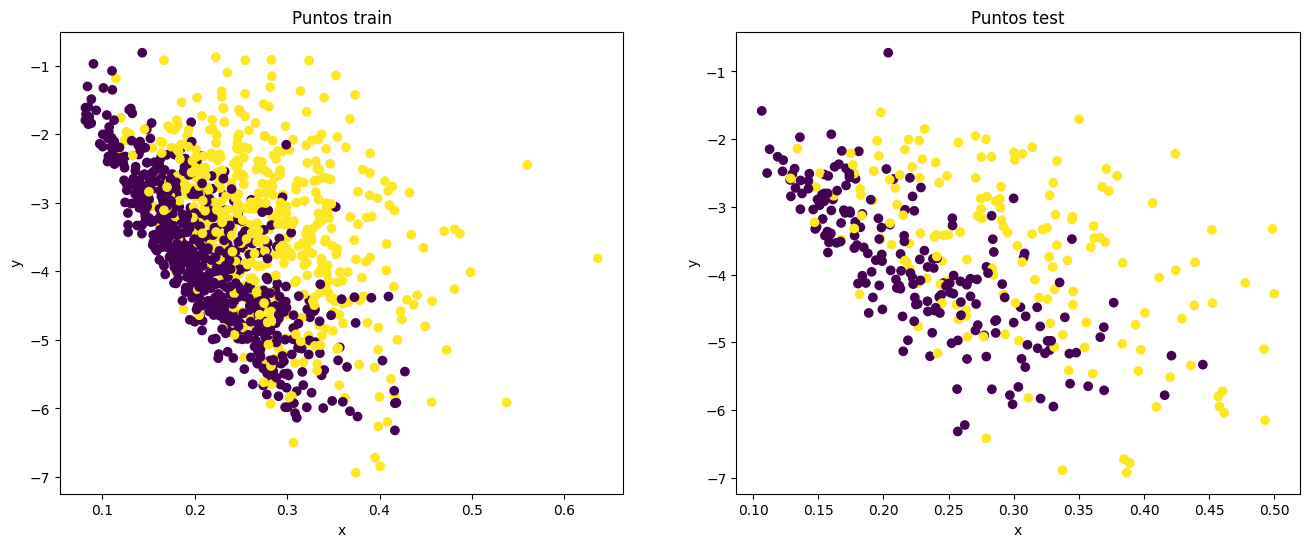

In [38]:
fig = plt.figure(figsize=(16,6))

ax1 = plt.subplot(1, 2, 1)
ax1.set_title("Puntos train")
ax1.set_xlabel("x")
ax1.set_ylabel("y") 
plt.scatter(x[:,1], x[:,2], c = y)

ax2 = plt.subplot(1, 2, 2)
ax2.set_title("Puntos test")
ax2.set_xlabel("x")
ax2.set_ylabel("y") 
plt.scatter(x_test[:,1], x_test[:,2], c = y_test)


In [39]:
def pla_pocket(x, y, max_iter, w_ini):
  
  changes = True
  iter = 0
  w = w_ini.copy()
  iter_optim = 0
  while changes == True and iter < max_iter:
    changes = False
    for i in range(x.shape[0]):
      if signo(w.dot(x[i])) != y[i]:
        w = w + y[i] * x[i]
        changes = True

      iter += 1
      if mc_rate_pla(x,y,w) < mc_rate_pla(x,y,w_ini):
        w_ini = w.copy()
        iter_optim = iter
        
      if iter >= max_iter:
        break

  return w_ini, iter_optim 



In [40]:
def pseudoinverse(x, y):
    u, d, vt = np.linalg.svd(x)
    d = d**-2
    d = np.diag(d)  
    return ((((vt.T @ d) @ vt) @ x.T) @ y)

In [41]:
def print_plt_and_line(x, y, x_test, y_test, w, lr = 0):
  fig = plt.figure(figsize=(16,6))

  xx = np.linspace([min(x[:,1]),max(x[:,1])], 100)

  ax1 = plt.subplot(1, 2, 1)
  ax1.set_title("Puntos muestreados train")
  ax1.set_xlabel("x")
  ax1.set_ylabel("y") 
  ax1.set_xlim([min(x[:,1]),max(x[:,1])])
  ax1.set_ylim([min(x[:,2]),max(x[:,2])])
  plt.scatter(x[:,1], x[:,2], c = y)

  wa = -w[1] / w[2]
  wyy = wa * xx - w[0] / w[2]
  plt.plot(xx, wyy, c = 'blue', label = "Recta W")

  ax2 = plt.subplot(1, 2, 2)
  ax2.set_title("Puntos muestreados test")
  ax2.set_xlabel("x")
  ax2.set_ylabel("y") 
  ax2.set_xlim([min(x_test[:,1]),max(x_test[:,1])])
  ax2.set_ylim([min(x_test[:,2]),max(x_test[:,2])])
  plt.scatter(x_test[:,1], x_test[:,2], c = y_test)

  plt.plot(xx, wyy, c = 'blue', label = "Recta W")

  mc_rate_in = mc_rate_pla(x, y, w)
  mc_rate_out = mc_rate_pla(x_test, y_test, w)

  print("W:", w)

  if lr == 1:
    ein = ein_rl(w,x,y)
    eout = ein_rl(w,x_test,y_test)
    print("Ein:",  ein)
    print("Eout:",  eout)

  else:
    print("Ein:",  mc_rate_in)
    print("Etest:",  mc_rate_out)


In [42]:
w_pocket, iter_pocket = pla_pocket(x.copy(), y.copy(), 150000, np.zeros(x.shape[1]))
w_pla, iter_pla = ajusta_PLA(x.copy(), y.copy(), 150000, np.zeros(x.shape[1]))
w_rl, iter_rl = sgdRL(x.copy(), y.copy(), 10, 64, 5000, np.zeros(x.shape[1]))
w_lr = pseudoinverse(x,y)

********************************** RESULTADOS PLA POCKET **********************************
W: [-4.         74.49745538  4.0733125 ]
Ein: 21.105527638190953
Etest: 25.136612021857925


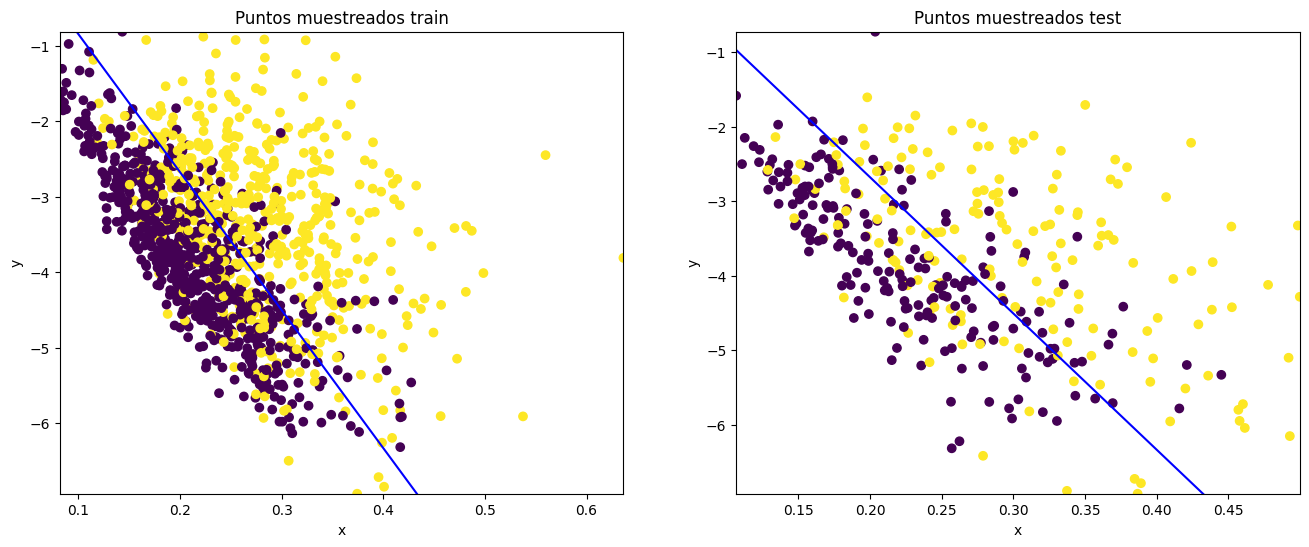

In [43]:
print("********************************** RESULTADOS PLA POCKET **********************************")
print_plt_and_line(x, y, x_test, y_test, w_pocket)


********************************** RESULTADOS PLA **********************************
W: [ -6.         170.09757892   9.3795    ]
Ein: 22.445561139028474
Etest: 26.50273224043716


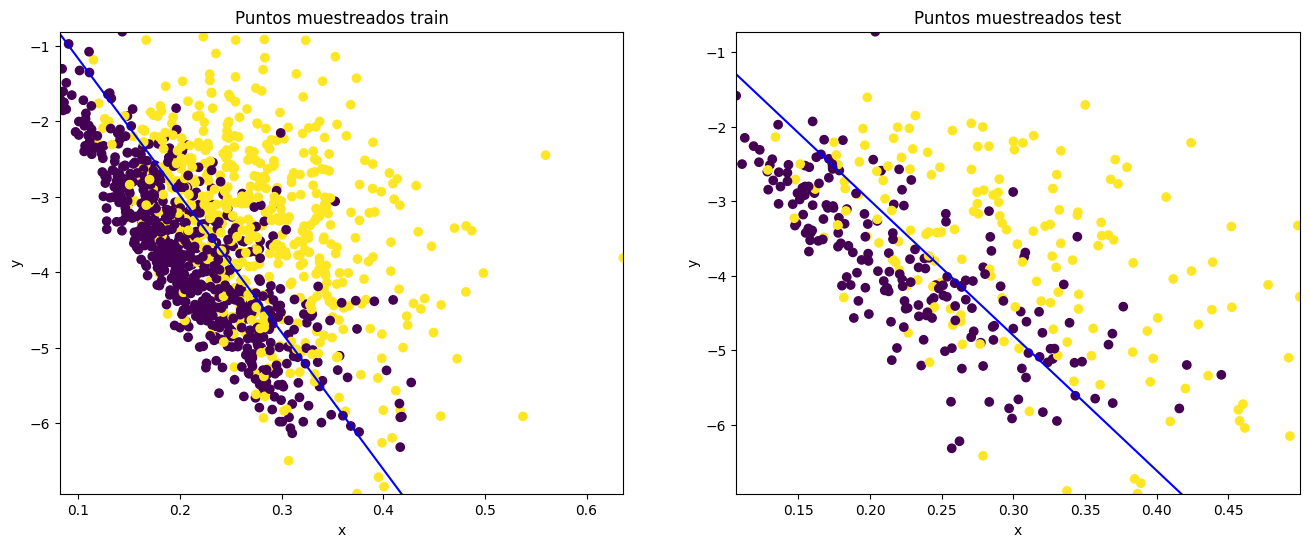

In [44]:
print("********************************** RESULTADOS PLA **********************************")
print_plt_and_line(x, y, x_test, y_test, w_pla)

********************************** RESULTADOS REGRESION LOGISTICA **********************************
W: [-10.36651537 311.98874807  18.69135798]
Ein: 2.386417561142203
Eout: 3.1506920181333085


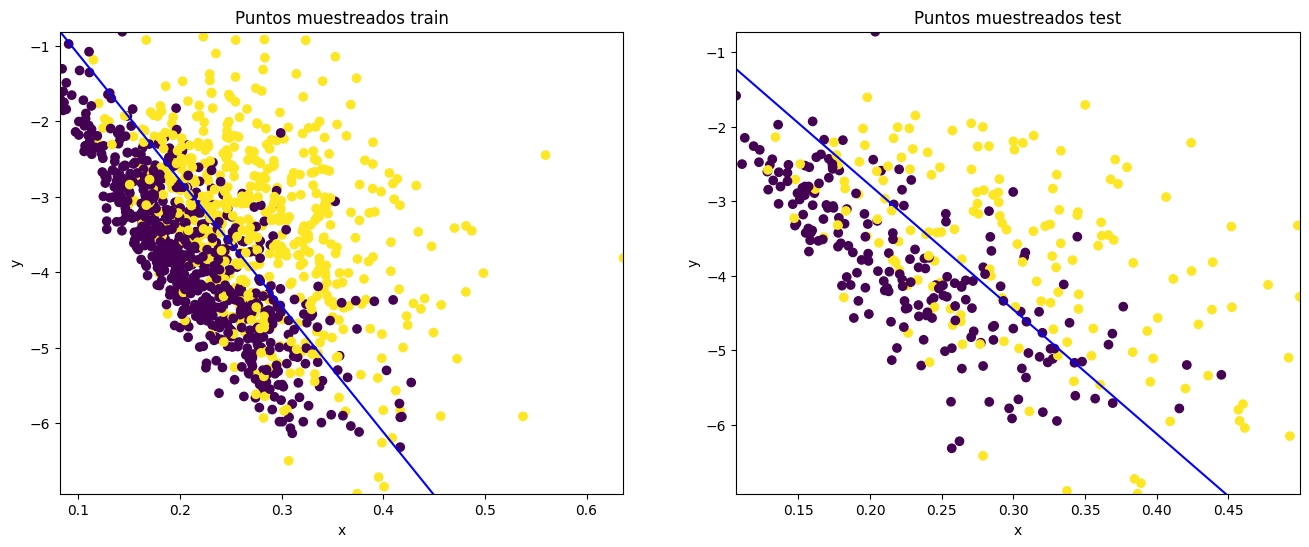

In [45]:
print("********************************** RESULTADOS REGRESION LOGISTICA **********************************")
print_plt_and_line(x, y, x_test, y_test, w_rl, lr = 1)

********************************** RESULTADOS REGRESION LINEAL **********************************
W: [-0.50676351  8.25119739  0.44464113]
Ein: 22.780569514237854
Etest: 25.136612021857925


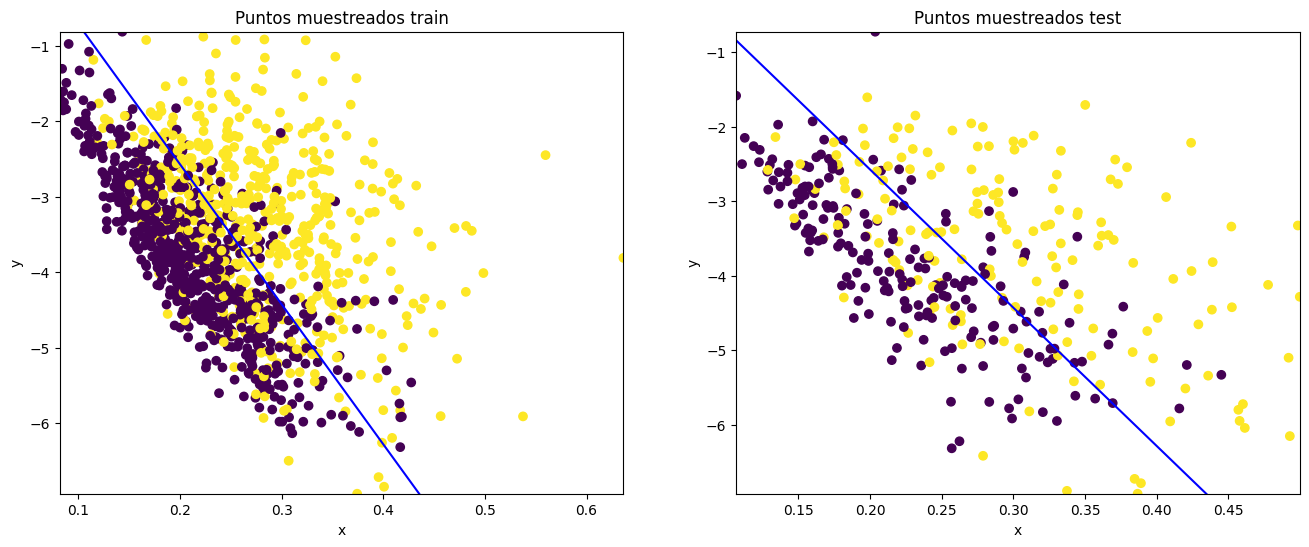

In [46]:
print("********************************** RESULTADOS REGRESION LINEAL **********************************")
print_plt_and_line(x, y, x_test, y_test, w_lr)

In [47]:
#Ejecutamos de nuevo los algoritmos pero usando como pesos iniciales los dados por la regresion lineal
w_pocket_2, iter_pocket_2 = pla_pocket(x.copy(), y.copy(), 150000, w_lr)
w_pla_2, iter_pla_2 = ajusta_PLA(x.copy(), y.copy(), 150000, w_lr)
w_rl_2, iter_rl_2 = sgdRL(x.copy(), y.copy(), 10, 64, 5000, w_lr)

In [48]:
print("Iteraciones en pocket con w0 vs w_lr :", iter_pocket, iter_pocket_2)
print("Iteraciones en pla con w0 vs w_lr :", iter_pla, iter_pla_2)
print("Iteraciones en regresion logistica con w0 vs w_lr :", iter_rl, iter_rl_2)


Iteraciones en pocket con w0 vs w_lr : 8303 60888
Iteraciones en pla con w0 vs w_lr : 150000 150000
Iteraciones en regresion logistica con w0 vs w_lr : 5000 5000


Los cambios que podemos ver respecto de iniciar los algoritmos con w0 vs w_lr es que en el pocket y regresion logistica tarda más en llegar al optimo del problema esto es debido a que son algoritmos de aprendizaje diferentes que utilizan enfoques distintos para ajustar los pesos. La regresión lineal ajusta los pesos para minimizar el error cuadrático , mientras que el perceptrón ajusta los pesos para clasificar correctamente los datos de entrenamiento mediante la actualización de los pesos y la regresion logistica en base a una condición de parada impuesta.
Esto nos hace ver que no se puede afirmar que si se utiliza el resultado de una regresión lineal como vector de pesos inicial para un algoritmo de aprendizaje como el perceptron o la regresion logistica este convergerá antes.

********************************** RESULTADOS POCKET CON W_LR **********************************
W: [-4.         74.49745538  4.0733125 ]
Ein: 21.105527638190953
Etest: 25.136612021857925


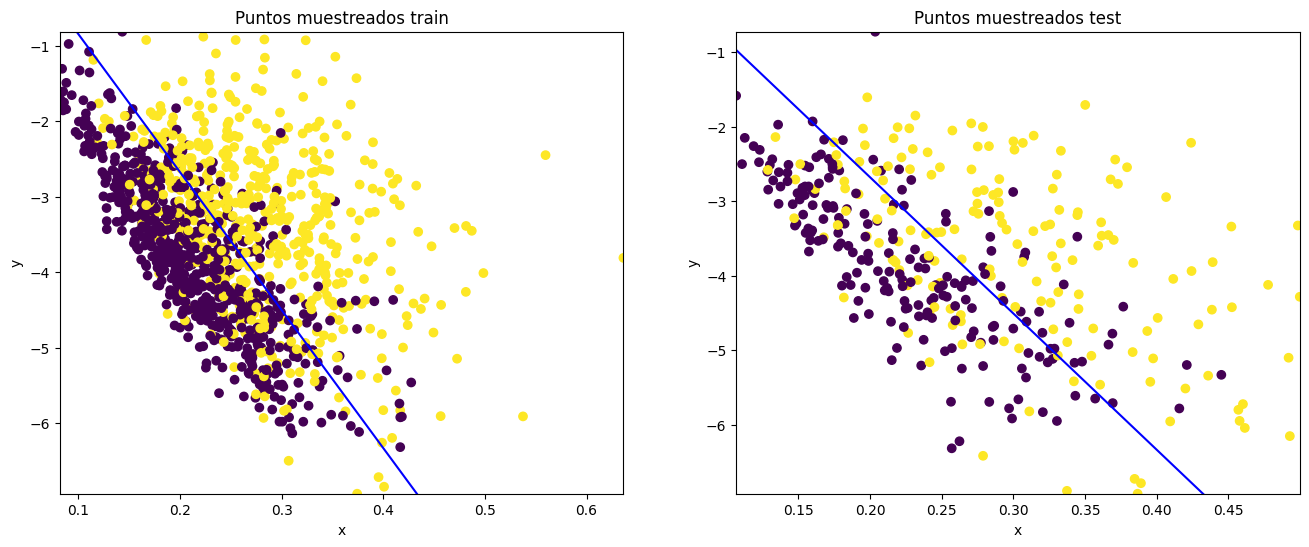

In [49]:
print("********************************** RESULTADOS POCKET CON W_LR **********************************")
print_plt_and_line(x, y, x_test, y_test, w_pocket)

********************************** RESULTADOS PLA CON W_LR **********************************
W: [ -6.         170.09757892   9.3795    ]
Ein: 22.445561139028474
Etest: 26.50273224043716


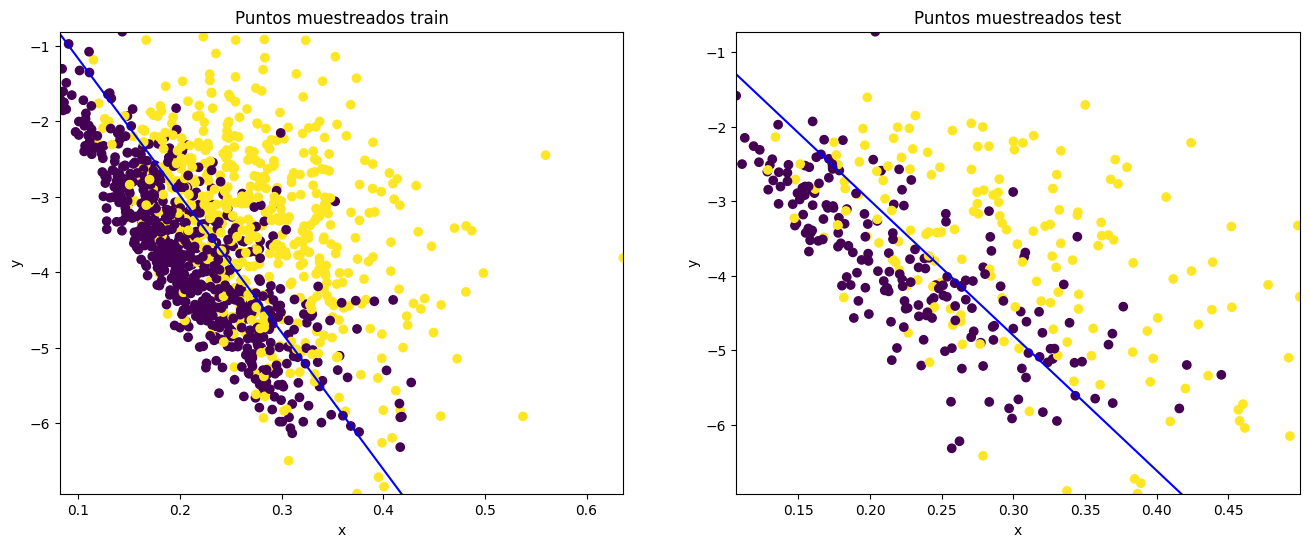

In [50]:
print("********************************** RESULTADOS PLA CON W_LR **********************************")
print_plt_and_line(x, y, x_test, y_test, w_pla)

********************************** RESULTADOS REGRESION LOGISTICA CON W_LR **********************************
W: [-10.36651537 311.98874807  18.69135798]
Ein: 21.691792294807367
Etest: 24.316939890710383


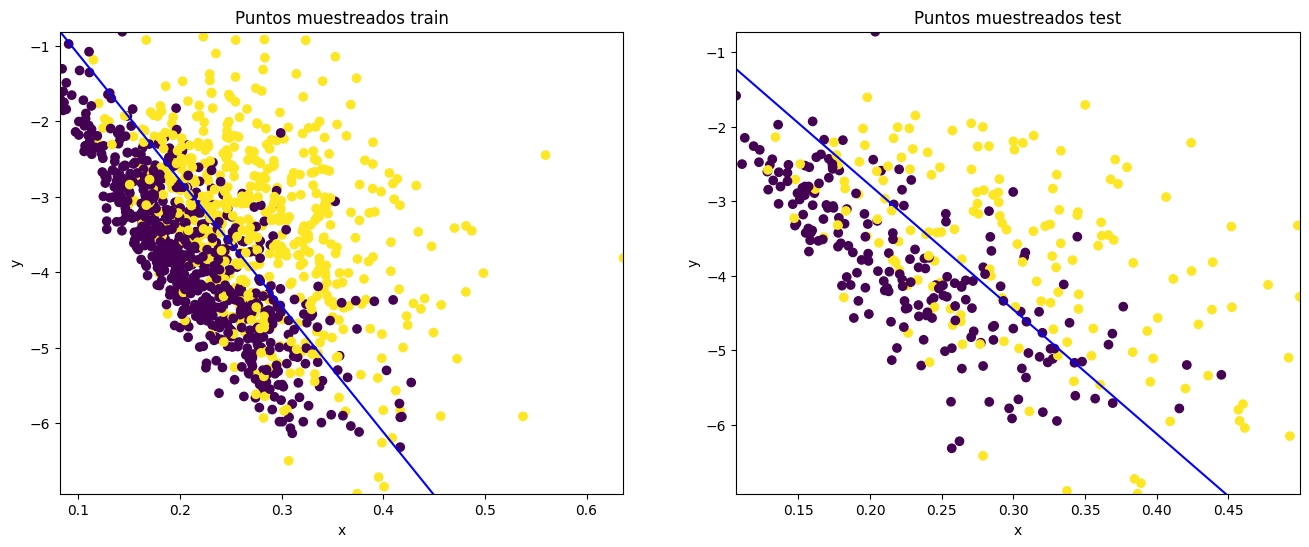

In [51]:
print("********************************** RESULTADOS REGRESION LOGISTICA CON W_LR **********************************")
print_plt_and_line(x, y, x_test, y_test, w_rl)

In [52]:
def e_out_1(ein, n, dvc, alpha):
  monstruo = (8/n * np.log10((4 * (2*n ** dvc) + 1) / alpha)) ** 0.5
  return ein + monstruo

def e_out_2(etest, n, h, alpha):
  monstruo = 1/(2*n) * np.log10(2*h/alpha)
  return etest + monstruo

In [53]:
alpha = 0.05
print("E_out 1 pocket = ", e_out_1(mc_rate_pla(x,y,w_pocket), x.shape[0], 3, alpha))
print("E_out 1 pla = ", e_out_1(mc_rate_pla(x,y,w_pla), x.shape[0], 3, alpha))
print("E_out 1 rl = ", e_out_1(mc_rate_pla(x,y,w_rl), x.shape[0], 3, alpha))
print("E_out 1 lr = ", e_out_1(mc_rate_pla(x,y,w_lr), x.shape[0], 3, alpha))

E_out 1 pocket =  21.38232595156228
E_out 1 pla =  22.7223594523998
E_out 1 rl =  21.968590608178694
E_out 1 lr =  23.05736782760918


In [54]:
print("E_out 2 pocket = ", e_out_2(mc_rate_pla(x_test,y_test,w_pocket), x.shape[0], 3, alpha))
print("E_out 2 pla = ", e_out_2(mc_rate_pla(x_test,y_test,w_pla), x.shape[0], 3, alpha))
print("E_out 2 rl = ", e_out_2(mc_rate_pla(x_test,y_test,w_rl), x.shape[0], 3, alpha))
print("E_out 2 lr = ", e_out_2(mc_rate_pla(x_test,y_test,w_lr), x.shape[0], 3, alpha))

E_out 2 pocket =  25.13748270077168
E_out 2 pla =  26.503602919350918
E_out 2 rl =  24.31781056962414
E_out 2 lr =  25.13748270077168
